# Library Install

model library install
```bash
pip install git+https://github.com/abcd-EGH/srnn-ae.git
```

In [11]:
!pip install git+https://github.com/abcd-EGH/srnn-ae.git -q
!pip install arch -q

In [3]:
from srnn_ae import ESLAE, TimeSeriesDataset, set_random_seed, hyperparameter_setting, read_dataset, train,\
                    data_plot_with_anomalies, compute_reconstruction_errors, evaluate_and_visualize
import os
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
import torch.optim as optim

In [4]:
# 가설 이름 설정
h_name = 'H1_BaseModel'

# machine_temperature_system_failure

## Ready to Train

In [88]:
set_random_seed()

# 하이퍼파라미터 및 가설 넘버 설정
args = hyperparameter_setting(N=10, hidden_size=8, num_layers=1, num_epochs=1000,
                              window_size=36, l1_lambda=1e-5, limit_skip_steps=10, learning_rate=1e-3)
file_name = './NAB/data/realKnownCause/machine_temperature_system_failure.csv'
h=os.path.join(h_name, os.path.basename(file_name).split('.')[0]) # 꼭 확인하기!
print("Hyperparameter & Hypothesis Number Setting Complete.")

# 디바이스 설정 (GPU가 사용 가능하면 GPU, 아니면 CPU)
model = ESLAE(
    N=args['N'], 
    input_size=args['input_size'],
    hidden_size=args['hidden_size'],
    output_size=args['output_size'],
    num_layers=args['num_layers'],
    limit_skip_steps=args['limit_skip_steps'],
    seed=args['random_seed'],
)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = model.to(device)
print("Model Initialization Complete.")

# Prepare data and create Dataset
abnormal_data, abnormal_label = read_dataset(file_name)
abnormal_data, abnormal_label = abnormal_data[:], abnormal_label[:]  # Remove last data point to fit window and batch size

window_size = args['window_size']
stride = 1

# Create the train dataset
train_dataset = TimeSeriesDataset(abnormal_data, abnormal_label, window_size, stride=stride)
batch_size = args['batch_size'] = len(train_dataset) # args['batch_size']

# Create DataLoaders
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=False, drop_last=True)
print("Data Load Complete.")

# 손실 함수 및 옵티마이저 설정 - 논문에선 Adadelta를 사용했으나, 20 epoch 동안 loss가 떨어지지 않아 Adam으로 대체
criterion = nn.MSELoss() # MSELoss, L1Loss, SmoothL1Loss
optimizer = optim.AdamW(model.parameters(), lr=args['learning_rate'], weight_decay=1e-5)
print("Loss function & Optimizer Complete.")

print("[Args]")
print(args)
print()

print("[Model]")
print(model)
print()

print("[Data]")
print(f"Number of samples in train dataset: {len(train_dataset)}")
print(f"Number of batches in train dataloader: {len(train_dataloader)}")
print()

print("[Criterion & Optimizer]")
print(criterion)
print(optimizer)
print()

Hyperparameter & Hypothesis Number Setting Complete.
Model Initialization Complete.
Processing file: realKnownCause/machine_temperature_system_failure.csv
Data Load Complete.
Loss function & Optimizer Complete.
[Args]
{'N': 10, 'input_size': 1, 'hidden_size': 8, 'output_size': 1, 'num_layers': 1, 'limit_skip_steps': 10, 'learning_rate': 0.001, 'l1_lambda': 1e-05, 'batch_size': 22660, 'window_size': 36, 'num_epochs': 1000, 'random_seed': 777}

[Model]
ESLAE(
  (autoencoders): ModuleList(
    (0-9): 10 x AutoEncoder(
      (encoder): Encoder(
        (cells): ModuleList(
          (0): sLSTMCell(
            (lstm): LSTMCell(1, 8)
          )
        )
      )
      (decoder): Decoder(
        (cells): ModuleList(
          (0): sLSTMCell(
            (lstm): LSTMCell(1, 8)
          )
        )
        (output_layer): Linear(in_features=8, out_features=1, bias=True)
      )
    )
  )
)

[Data]
Number of samples in train dataset: 22660
Number of batches in train dataloader: 1

[Criterion

## Train

In [ ]:
# 학습 실행
print('현재 가설명:', h)
print()

train(
    model=model,
    dataloader=train_dataloader,
    criterion=criterion,
    optimizer=optimizer,
    device=device,
    l1_lambda=args['l1_lambda'],
    num_epochs=args['num_epochs'],
    h=h
)

현재 가설명: H1_BaseModel\machine_temperature_system_failure

Epoch [1/1000], Loss: 0.707471, (Duration: 4.57s, Current Time: 00:39:44, Estimated End Time: 01:55:52)
Epoch [50/1000], Loss: 0.221747, (Duration: 3.79s, Current Time: 00:42:46, Estimated End Time: 01:42:45)
Epoch [100/1000], Loss: 0.044487, (Duration: 4.91s, Current Time: 00:46:03, Estimated End Time: 01:59:39)


In [105]:
# 모델 가중치 저장
torch.save(model.state_dict(), f'results/{h}/ensemble_autoencoder_weights.pth')
print(f"모델 가중치가 {h}/ensemble_autoencoder_weights.pth'에 저장되었습니다.")

모델 가중치가 H1_BaseModel\machine_temperature_system_failure/ensemble_autoencoder_weights.pth'에 저장되었습니다.


## Test

In [65]:
model.load_state_dict(torch.load(f'results/{h}/ensemble_autoencoder_weights.pth', weights_only=True))
print("모델 가중치가 로드되었습니다.")

모델 가중치가 로드되었습니다.


In [86]:
# 테스트 파일 불러오기
test_file_name = file_name # Train한 file과 동일한 file로 진행
test_abnormal_data, test_abnormal_label = read_dataset(test_file_name)
test_abnormal_data, test_abnormal_label = test_abnormal_data[:], test_abnormal_label[:]

# 모든 데이터를 테스트에 사용
test_dataset = TimeSeriesDataset(test_abnormal_data, test_abnormal_label, window_size)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, drop_last=True)

total_length = len(test_abnormal_data)

all_errors, reconstructed_data, binary_labels = compute_reconstruction_errors(model, test_dataloader, device, total_length, test_abnormal_label)

Processing file: realKnownCause/machine_temperature_system_failure.csv
Testing Complete.


Using static Reconstruction Error Threshold (95th percentile): 0.020494
[Classification Metrics]
Precision: 0.7612
Recall: 0.3810
F1-Score: 0.5078
ROC AUC: 0.6618
PR AUC: 0.4885
Cohen Kappa: 0.4726

Reconstruction error plot saved to results\H1_BaseModel\machine_temperature_system_failure/StaticThreshold\reconstruction_error_static_threshold.png


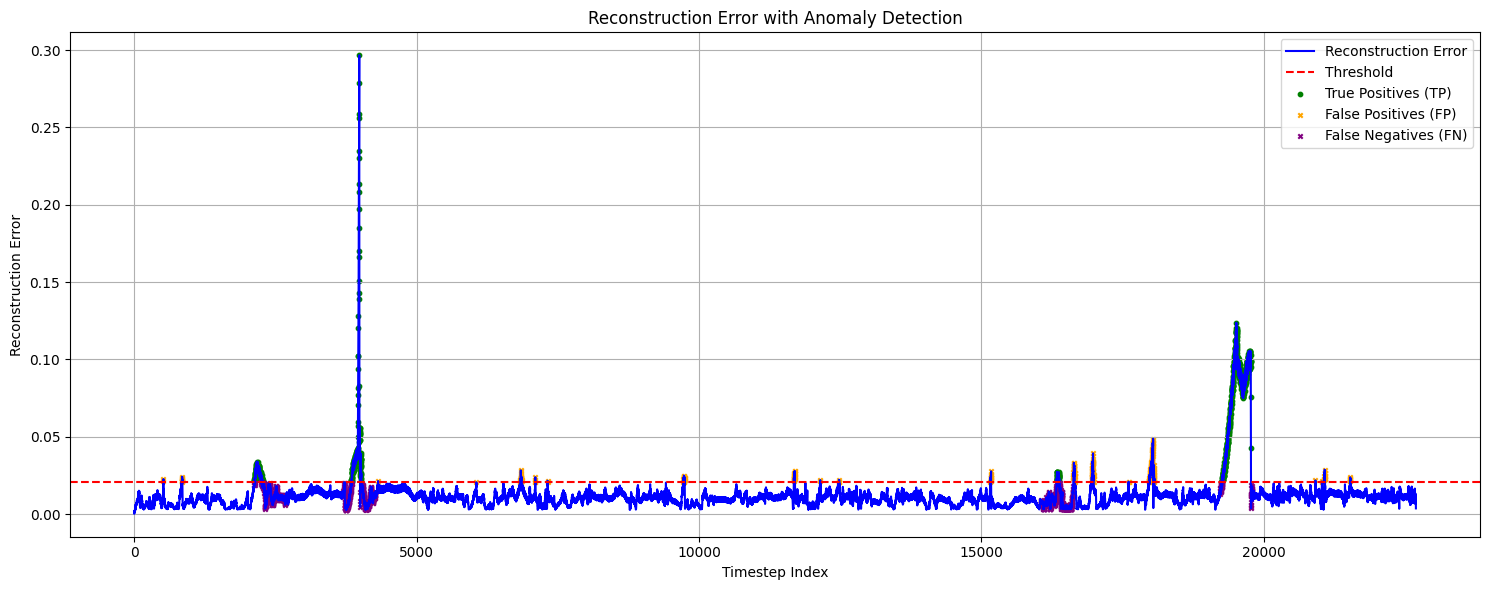

Actual vs Reconstructed Data plot saved to results\H1_BaseModel\machine_temperature_system_failure/StaticThreshold\actual_vs_reconstructed_data.png


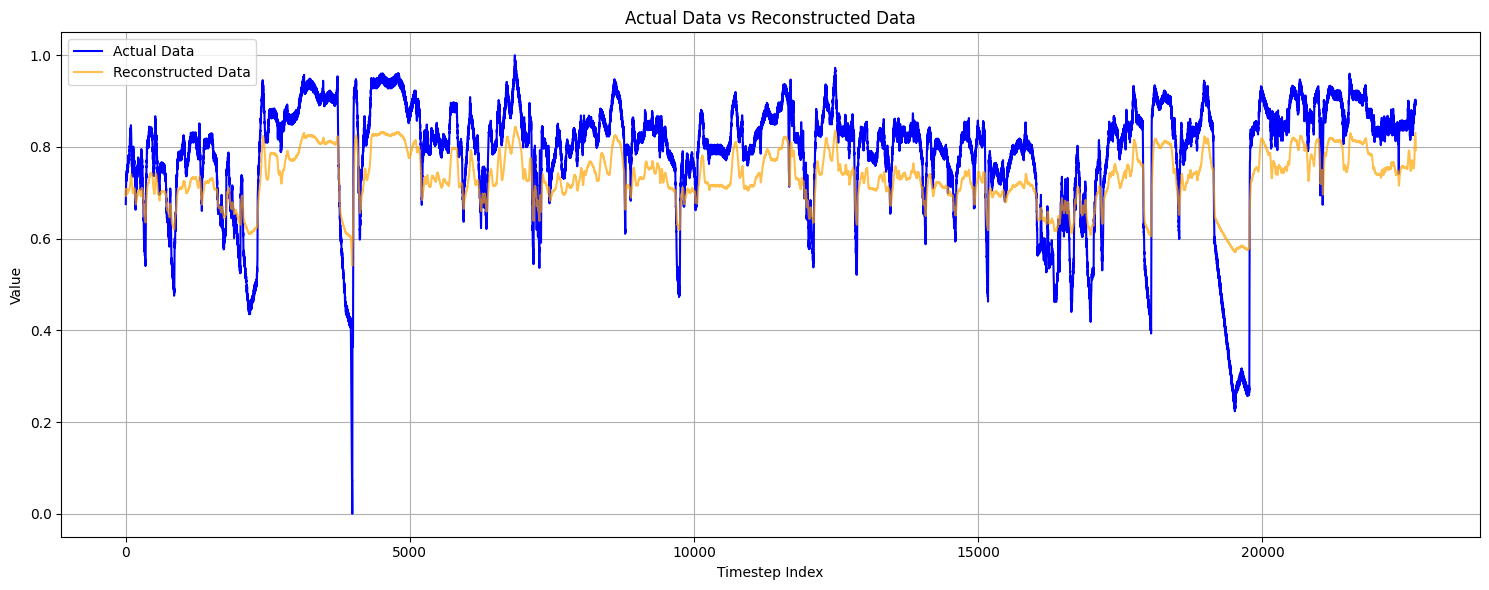

ROC curve plot saved to results\H1_BaseModel\machine_temperature_system_failure/StaticThreshold\roc_curve_all_data.png


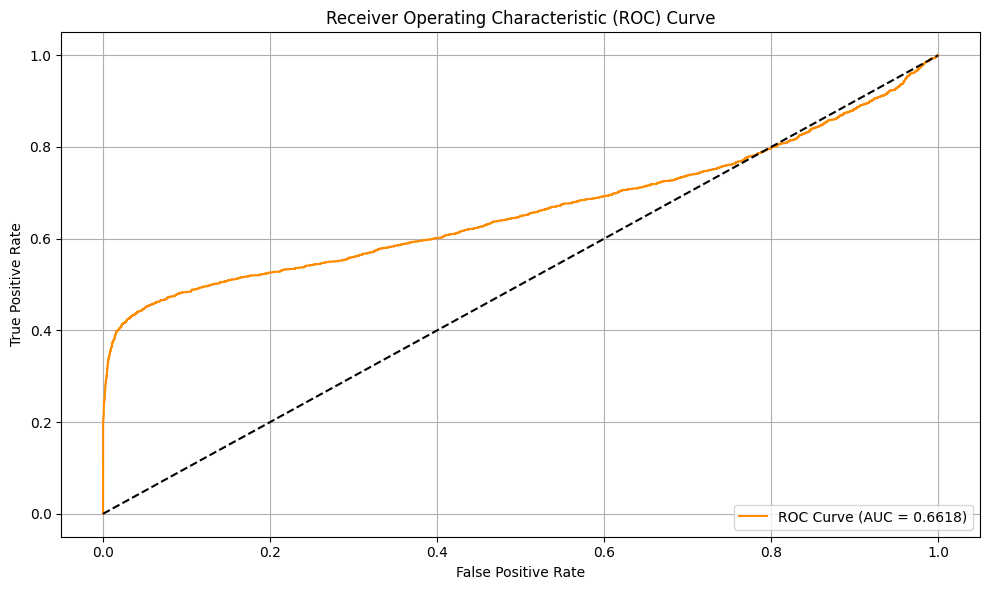

PR curve plot saved to results\H1_BaseModel\machine_temperature_system_failure/StaticThreshold\pr_curve_all_data.png


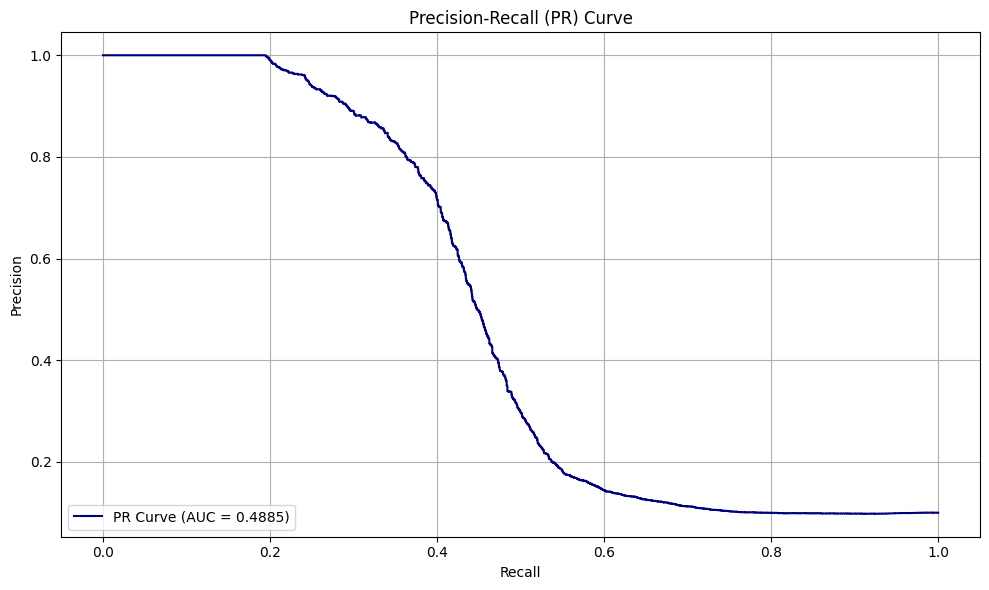

Confusion matrix plot saved to results\H1_BaseModel\machine_temperature_system_failure/StaticThreshold\confusion_matrix.png


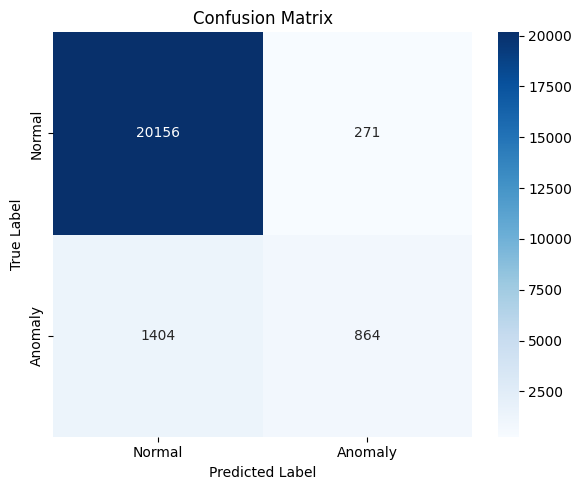

Reconstruction error with anomalies plot saved to results\H1_BaseModel\machine_temperature_system_failure/StaticThreshold\reconstruction_error_with_anomalies_static.png


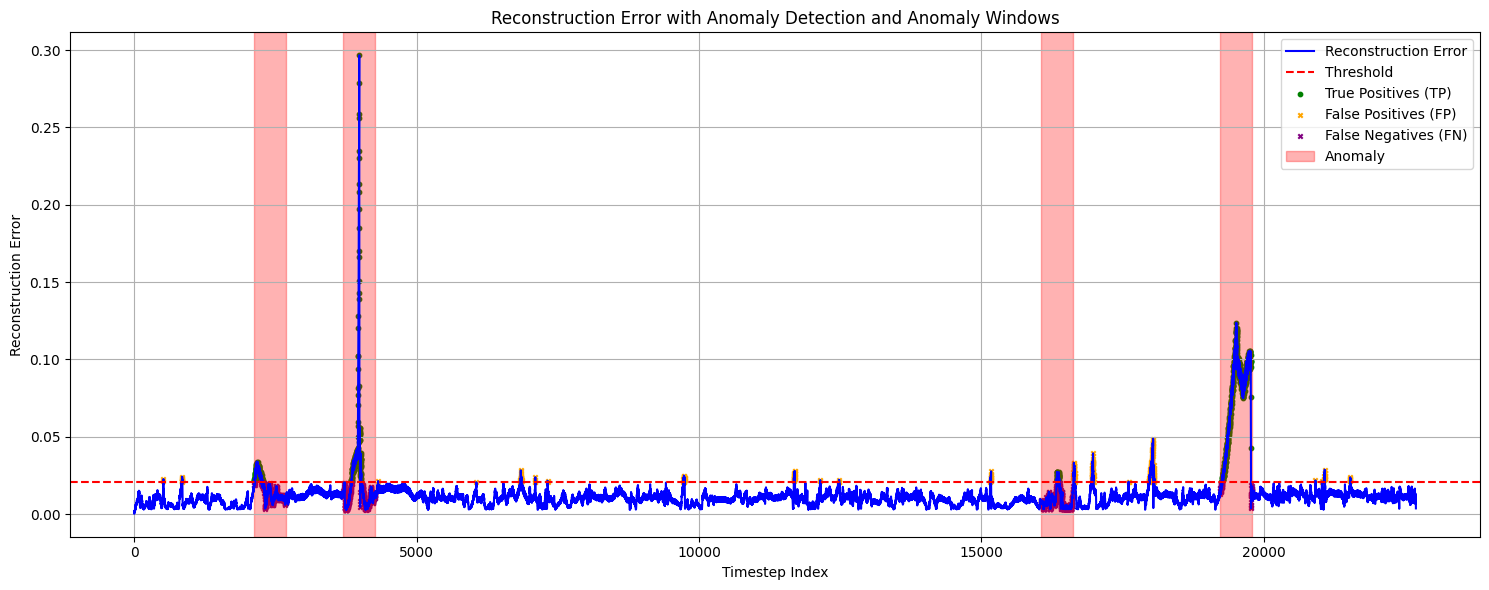

In [87]:
# 테스트 실행 (Static Threshold)
evaluate_and_visualize(
    all_errors=all_errors,
    reconstructed_data=reconstructed_data,
    binary_labels=binary_labels,
    actual_data=test_abnormal_data,
    h=h+'/StaticThreshold',
    threshold_method='static',
    threshold_percentile=95,
)

Using dynamic Reconstruction Error Threshold based on 20-window moving average and 1.0*std
[Classification Metrics]
Precision: 0.1262
Recall: 0.3038
F1-Score: 0.1783
ROC AUC: 0.7942
PR AUC: 0.5549
Cohen Kappa: 0.0432

Reconstruction error plot saved to results\H1_BaseModel\machine_temperature_system_failure/DynamicThresholdwithMA\reconstruction_error_moving_avg_threshold.png


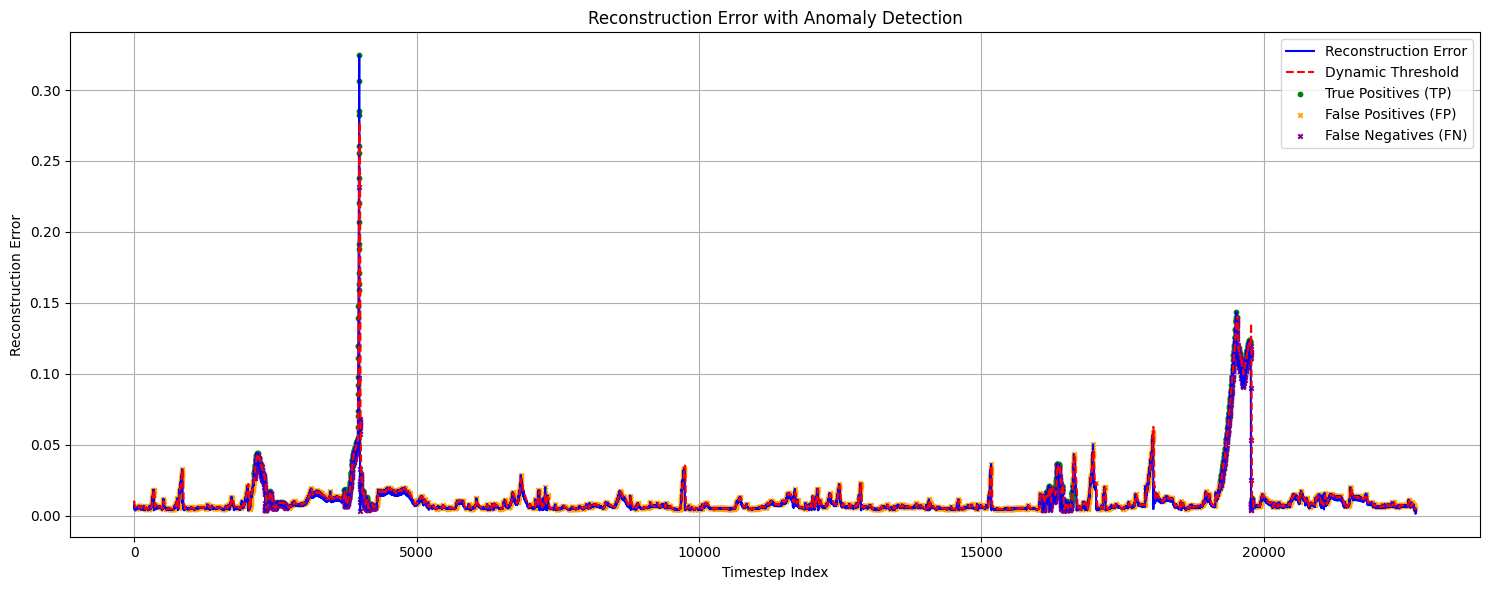

Actual vs Reconstructed Data plot saved to results\H1_BaseModel\machine_temperature_system_failure/DynamicThresholdwithMA\actual_vs_reconstructed_data.png


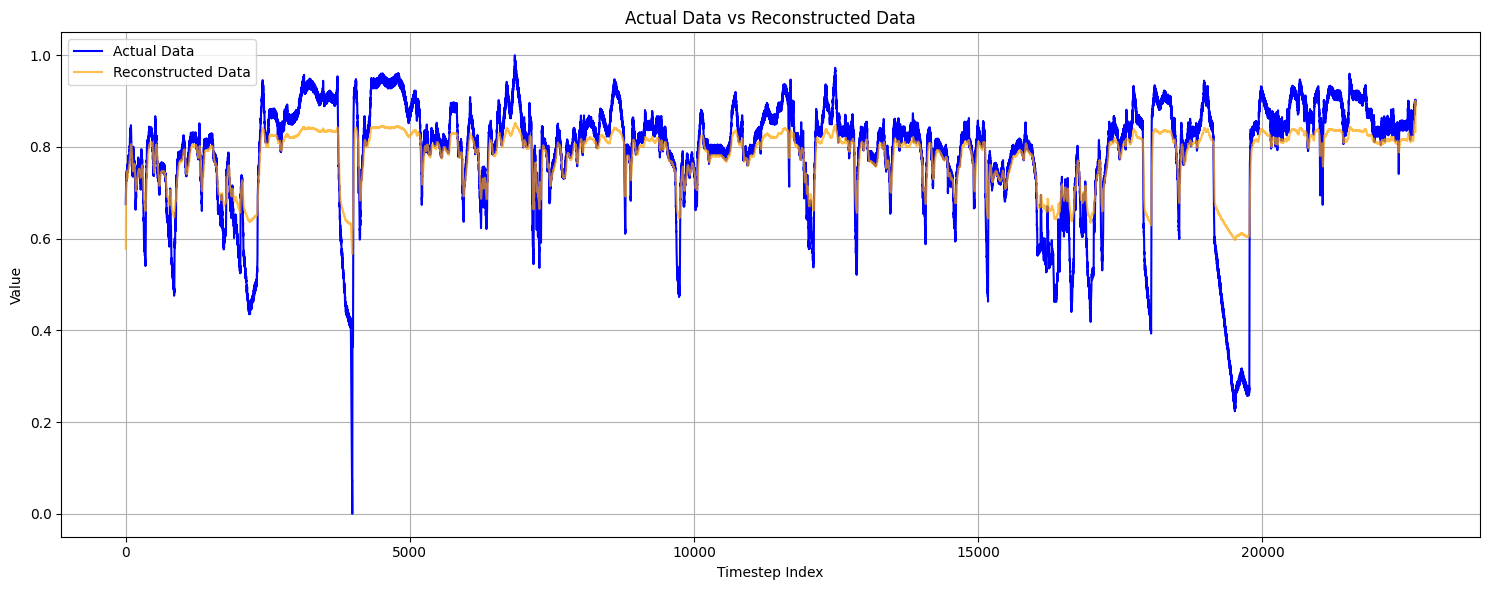

ROC curve plot saved to results\H1_BaseModel\machine_temperature_system_failure/DynamicThresholdwithMA\roc_curve_all_data.png


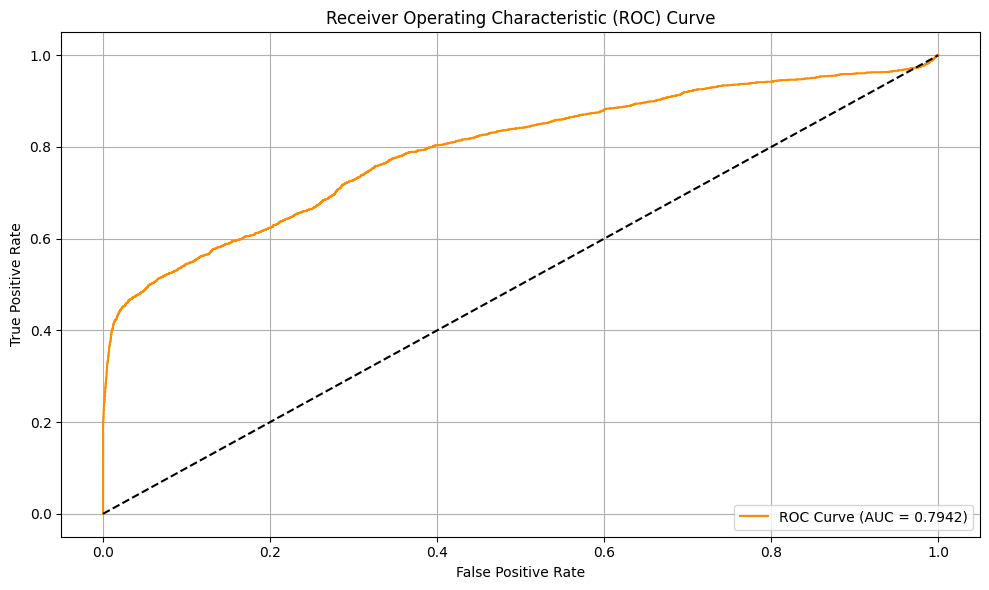

PR curve plot saved to results\H1_BaseModel\machine_temperature_system_failure/DynamicThresholdwithMA\pr_curve_all_data.png


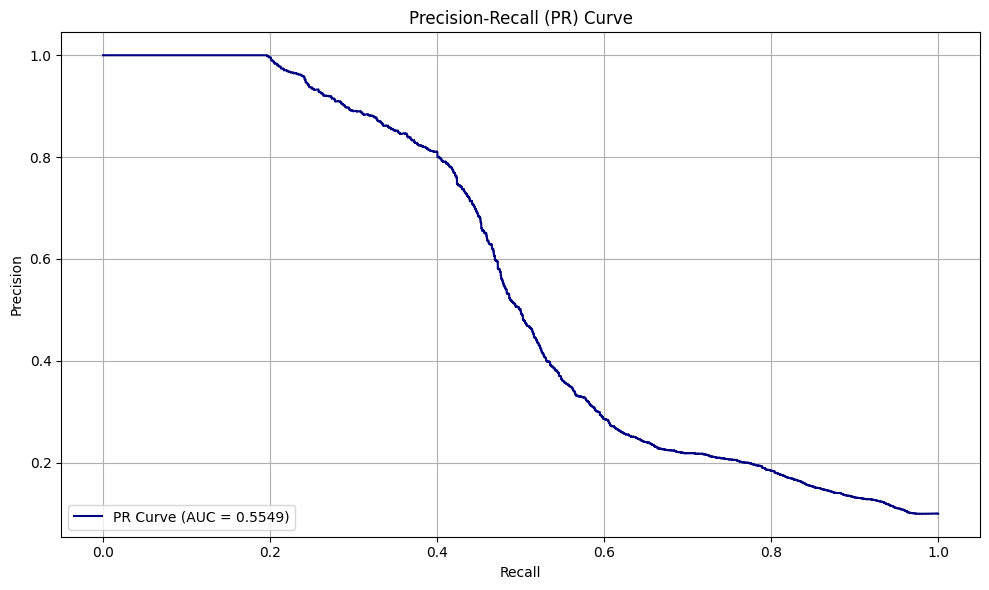

Confusion matrix plot saved to results\H1_BaseModel\machine_temperature_system_failure/DynamicThresholdwithMA\confusion_matrix.png


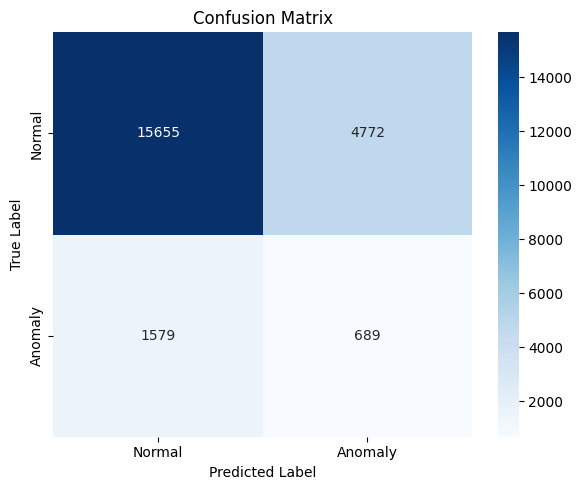

Reconstruction error with anomalies plot saved to results\H1_BaseModel\machine_temperature_system_failure/DynamicThresholdwithMA\reconstruction_error_with_anomalies_moving_avg.png


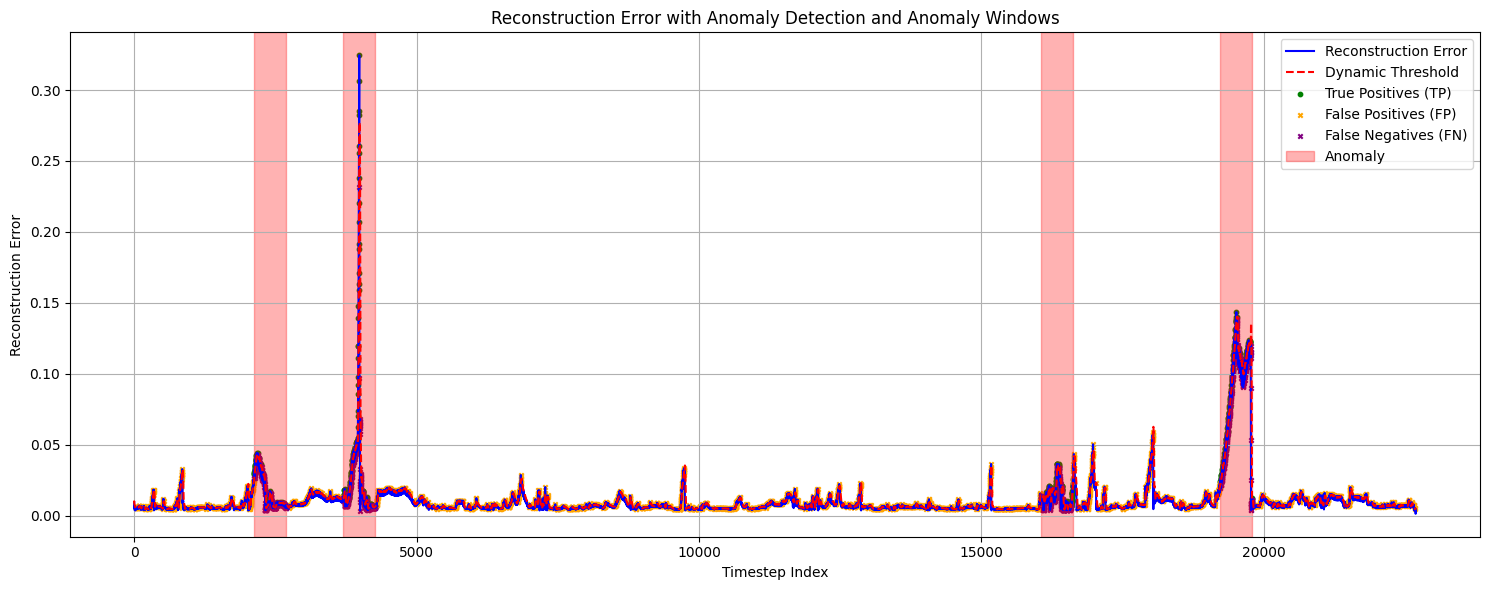

In [117]:
# 테스트 실행 (Dynamic Threshold, Moving Average)
evaluate_and_visualize(
    all_errors=all_errors,
    reconstructed_data=reconstructed_data,
    binary_labels=binary_labels,
    actual_data=test_abnormal_data,
    h=h+'/DynamicThresholdwithMA',
    threshold_method='moving_avg',
    k=1.0
)

Fitting GARCH(1,1) model on scaled reconstruction errors...
                       Zero Mean - GARCH Model Results                        
Dep. Variable:                      y   R-squared:                       0.000
Mean Model:                 Zero Mean   Adj. R-squared:                  0.000
Vol Model:                      GARCH   Log-Likelihood:                169684.
Distribution:                  Normal   AIC:                          -339363.
Method:            Maximum Likelihood   BIC:                          -339339.
                                        No. Observations:                22695
Date:                Wed, Dec 04 2024   Df Residuals:                    22695
Time:                        01:46:17   Df Model:                            0
                              Volatility Model                              
                 coef    std err          t      P>|t|      95.0% Conf. Int.
---------------------------------------------------------------------------

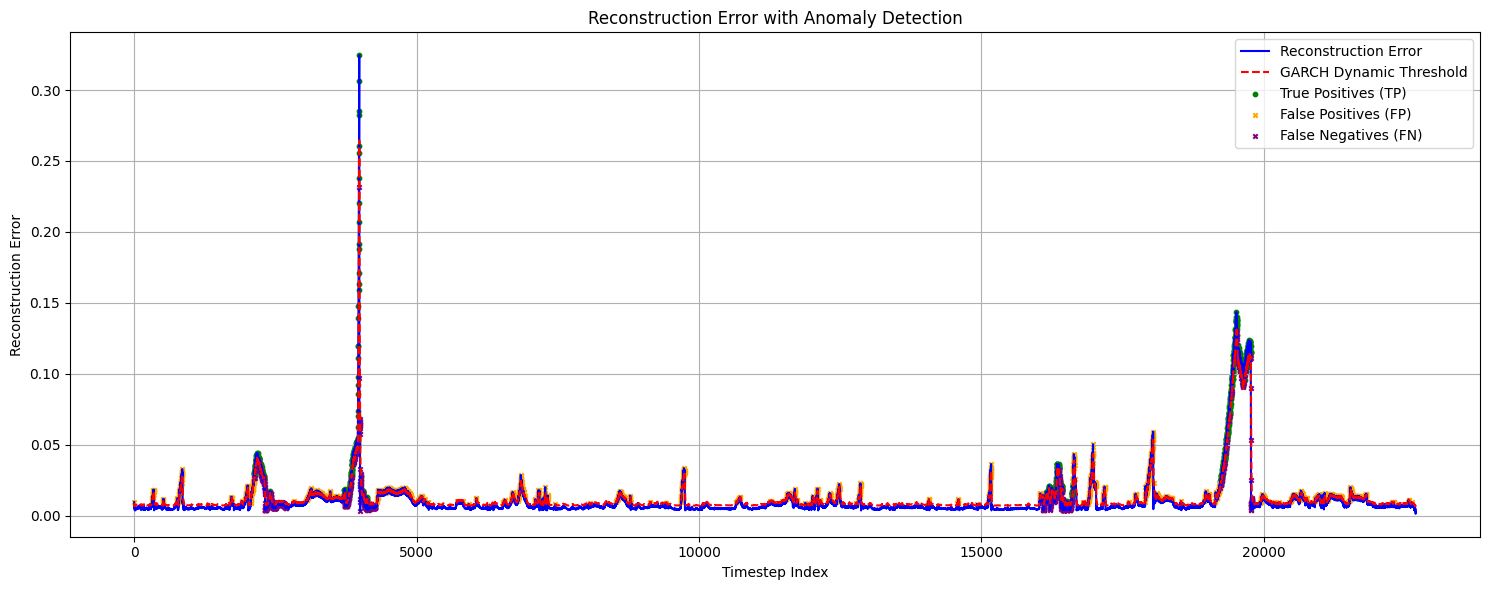

Actual vs Reconstructed Data plot saved to results\H1_BaseModel\machine_temperature_system_failure/DynamicThresholdwithGARCH\actual_vs_reconstructed_data.png


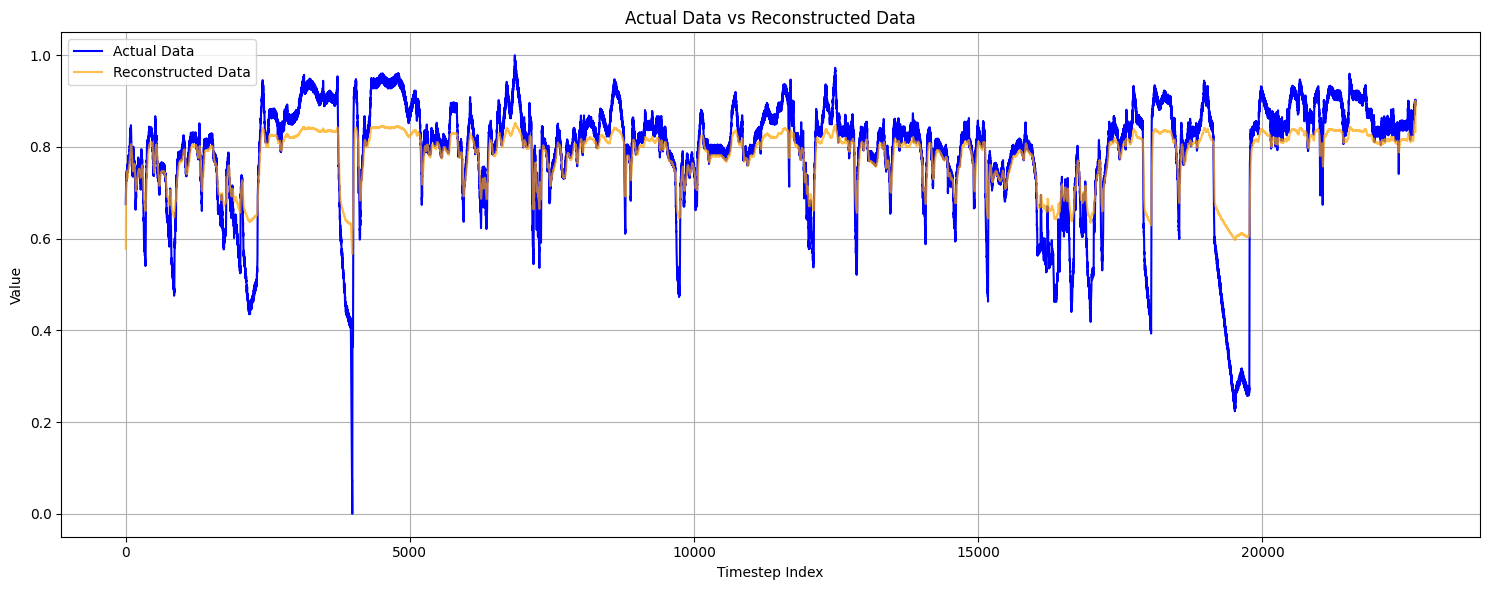

ROC curve plot saved to results\H1_BaseModel\machine_temperature_system_failure/DynamicThresholdwithGARCH\roc_curve_all_data.png


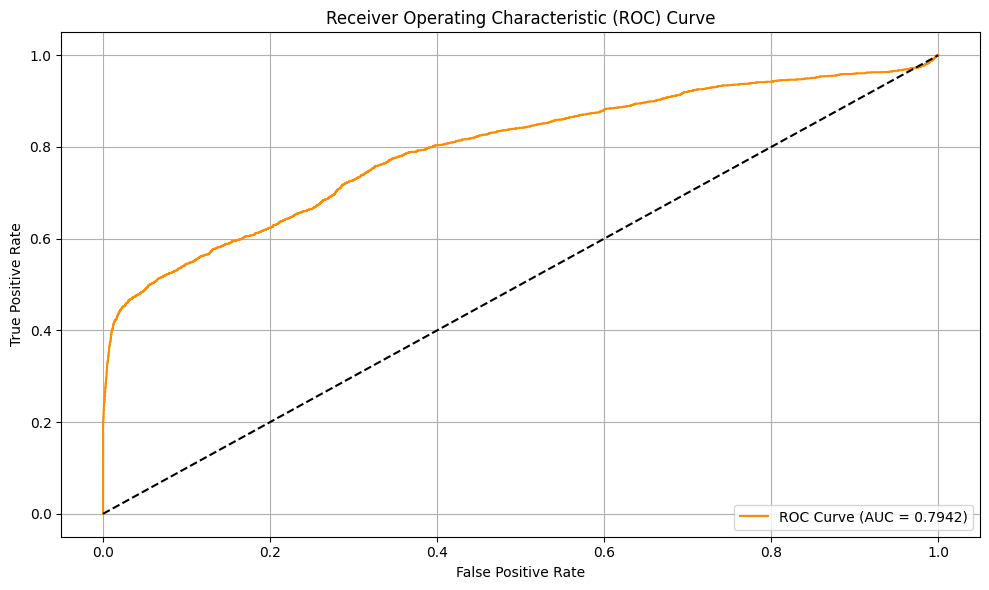

PR curve plot saved to results\H1_BaseModel\machine_temperature_system_failure/DynamicThresholdwithGARCH\pr_curve_all_data.png


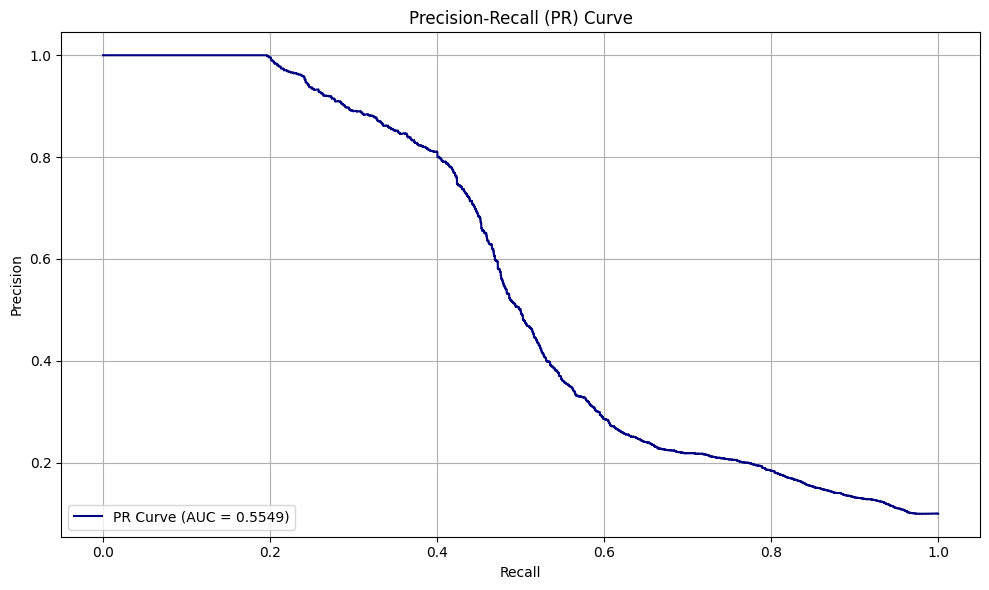

Confusion matrix plot saved to results\H1_BaseModel\machine_temperature_system_failure/DynamicThresholdwithGARCH\confusion_matrix.png


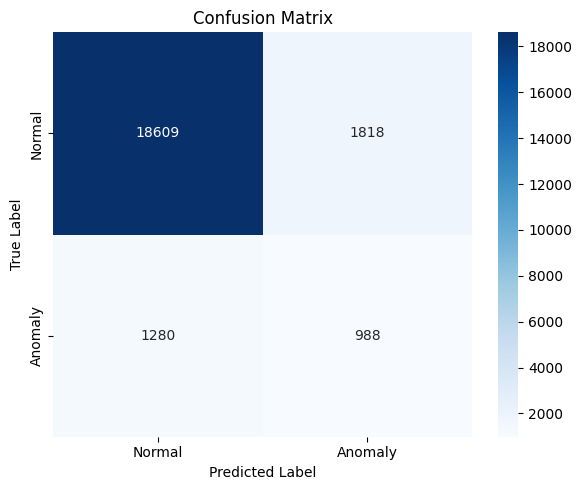

Reconstruction error with anomalies plot saved to results\H1_BaseModel\machine_temperature_system_failure/DynamicThresholdwithGARCH\reconstruction_error_with_anomalies_garch.png


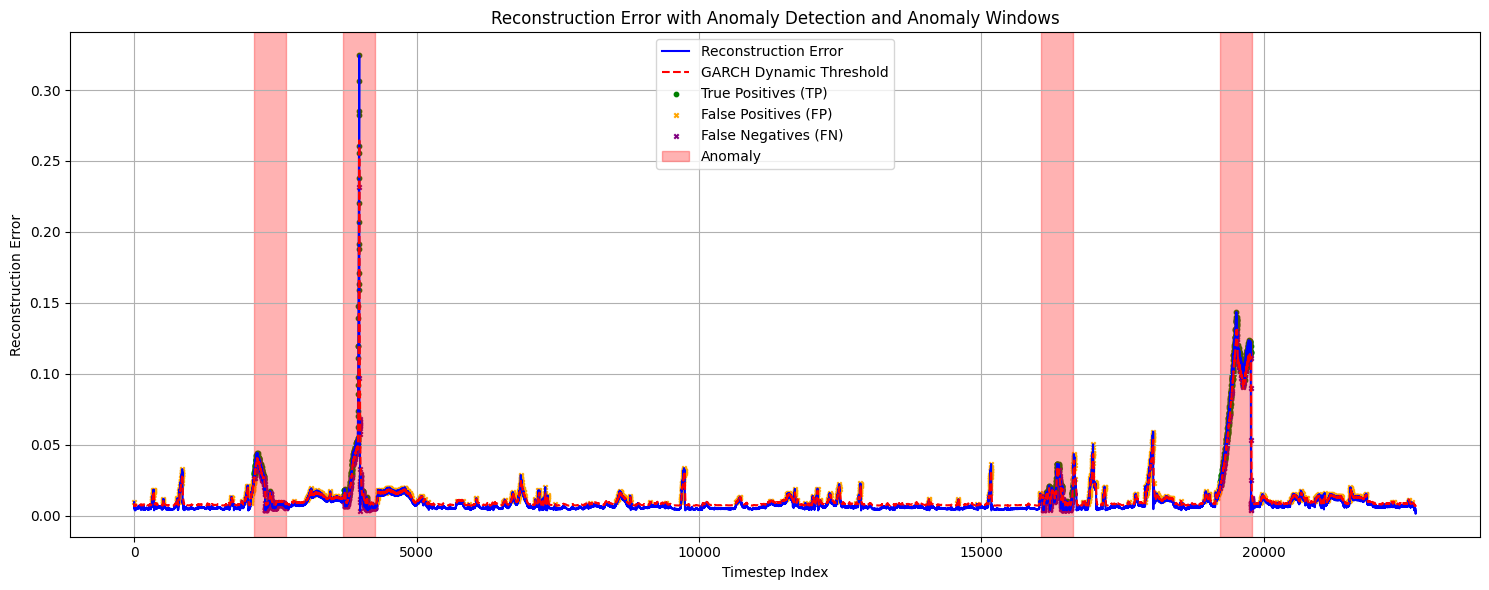

In [118]:
# 테스트 실행 (Dynamic Threshold, GARCH)
evaluate_and_visualize(
    all_errors=all_errors,
    reconstructed_data=reconstructed_data,
    binary_labels=binary_labels,
    actual_data=test_abnormal_data,
    h=h+'/DynamicThresholdwithGARCH',
    threshold_method='garch',
    k=1.0,
)

# ec2_cpu_utilization_825cc2

## Train

Hyperparameter & Hypothesis Number Setting Complete.
Model Initialization Complete.
Processing file: realAWSCloudwatch/ec2_cpu_utilization_825cc2.csv
Data Load Complete.
Loss function & Optimizer Complete.
[Args]
{'N': 10, 'input_size': 1, 'hidden_size': 8, 'output_size': 1, 'num_layers': 1, 'limit_skip_steps': 10, 'learning_rate': 0.001, 'l1_lambda': 1e-05, 'batch_size': 3997, 'window_size': 36, 'num_epochs': 1000, 'random_seed': 777}

[Model]
ESLAE(
  (autoencoders): ModuleList(
    (0-9): 10 x AutoEncoder(
      (encoder): Encoder(
        (cells): ModuleList(
          (0): sLSTMCell(
            (lstm): LSTMCell(1, 8)
          )
        )
      )
      (decoder): Decoder(
        (cells): ModuleList(
          (0): sLSTMCell(
            (lstm): LSTMCell(1, 8)
          )
        )
        (output_layer): Linear(in_features=8, out_features=1, bias=True)
      )
    )
  )
)

[Data]
Number of samples in train dataset: 3997
Number of batches in train dataloader: 1

[Criterion & Opti

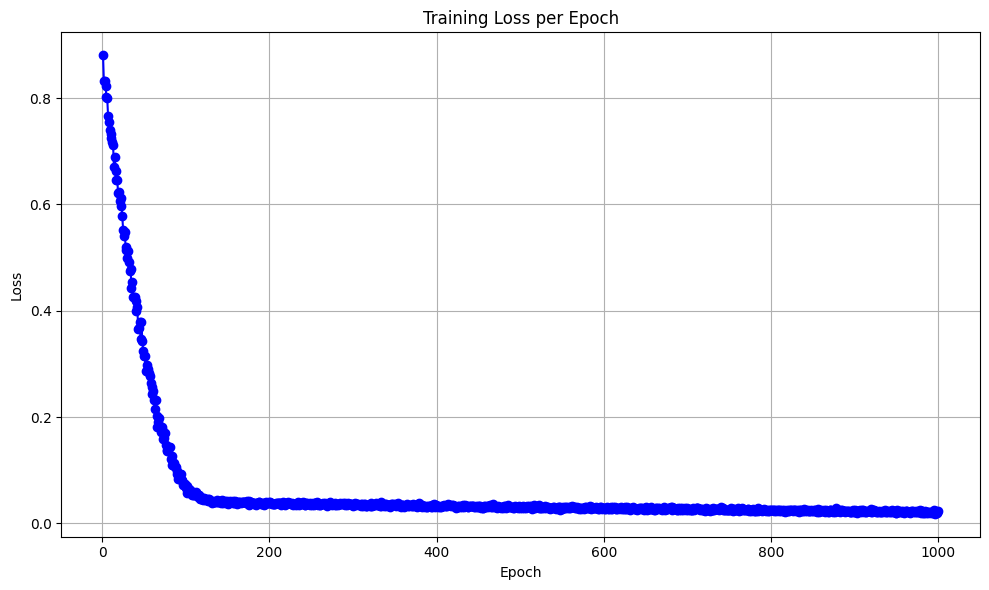

In [11]:
set_random_seed()

# 하이퍼파라미터 및 가설 넘버 설정
args = hyperparameter_setting(N=10, hidden_size=8, num_layers=1, num_epochs=1000,
                              window_size=36, l1_lambda=1e-5, limit_skip_steps=10, learning_rate=1e-3)
file_name = './NAB/data/realAWSCloudwatch/ec2_cpu_utilization_825cc2.csv'
h=os.path.join(h_name, os.path.basename(file_name).split('.')[0]) # 꼭 확인하기!
print("Hyperparameter & Hypothesis Number Setting Complete.")

# 디바이스 설정 (GPU가 사용 가능하면 GPU, 아니면 CPU)
model = ESLAE(
    N=args['N'], 
    input_size=args['input_size'],
    hidden_size=args['hidden_size'],
    output_size=args['output_size'],
    num_layers=args['num_layers'],
    limit_skip_steps=args['limit_skip_steps'],
    seed=args['random_seed'],
)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = model.to(device)
print("Model Initialization Complete.")

# Prepare data and create Dataset
abnormal_data, abnormal_label = read_dataset(file_name)
abnormal_data, abnormal_label = abnormal_data[:], abnormal_label[:]  # Remove last data point to fit window and batch size

window_size = args['window_size']
stride = 1

# Create the train dataset
train_dataset = TimeSeriesDataset(abnormal_data, abnormal_label, window_size, stride=stride)
batch_size = args['batch_size'] = len(train_dataset) # args['batch_size']

# Create DataLoaders
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=False, drop_last=True)
print("Data Load Complete.")

# 손실 함수 및 옵티마이저 설정 - 논문에선 Adadelta를 사용했으나, 20 epoch 동안 loss가 떨어지지 않아 Adam으로 대체
criterion = nn.MSELoss() # MSELoss, L1Loss, SmoothL1Loss
optimizer = optim.AdamW(model.parameters(), lr=args['learning_rate'], weight_decay=1e-5)
print("Loss function & Optimizer Complete.")

print("[Args]")
print(args)
print()

print("[Model]")
print(model)
print()

print("[Data]")
print(f"Number of samples in train dataset: {len(train_dataset)}")
print(f"Number of batches in train dataloader: {len(train_dataloader)}")
print()

print("[Criterion & Optimizer]")
print(criterion)
print(optimizer)
print()

# 학습 실행
print('현재 가설명:', h)
print()

train(
    model=model,
    dataloader=train_dataloader,
    criterion=criterion,
    optimizer=optimizer,
    device=device,
    l1_lambda=args['l1_lambda'],
    num_epochs=args['num_epochs'],
    h=h
)

## Test

In [28]:
# 모델 가중치 저장
torch.save(model.state_dict(), f'results/{h}/ensemble_autoencoder_weights.pth')
print(f"모델 가중치가 {h}/ensemble_autoencoder_weights.pth'에 저장되었습니다.")

model.load_state_dict(torch.load(f'results/{h}/ensemble_autoencoder_weights.pth', weights_only=True))
print("모델 가중치가 로드되었습니다.")

# 테스트 파일 불러오기
test_file_name = file_name # Train한 file과 동일한 file로 진행
test_abnormal_data, test_abnormal_label = read_dataset(test_file_name)
test_abnormal_data, test_abnormal_label = test_abnormal_data[:], test_abnormal_label[:]

# 모든 데이터를 테스트에 사용
test_dataset = TimeSeriesDataset(test_abnormal_data, test_abnormal_label, window_size)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, drop_last=True)

total_length = len(test_abnormal_data)

all_errors, reconstructed_data, binary_labels = compute_reconstruction_errors(model, test_dataloader, device, total_length, test_abnormal_label)

모델 가중치가 H1_BaseModel\ec2_cpu_utilization_825cc2/ensemble_autoencoder_weights.pth'에 저장되었습니다.
모델 가중치가 로드되었습니다.
Processing file: realAWSCloudwatch/ec2_cpu_utilization_825cc2.csv
Testing Complete.


Using static Reconstruction Error Threshold (95th percentile): 0.012934
[Classification Metrics]
Precision: 0.5347
Recall: 0.3149
F1-Score: 0.3963
ROC AUC: 0.6014
PR AUC: 0.3086
Cohen Kappa: 0.3557

Reconstruction error plot saved to results\H1_BaseModel\ec2_cpu_utilization_825cc2/StaticThreshold\reconstruction_error_static_threshold.png


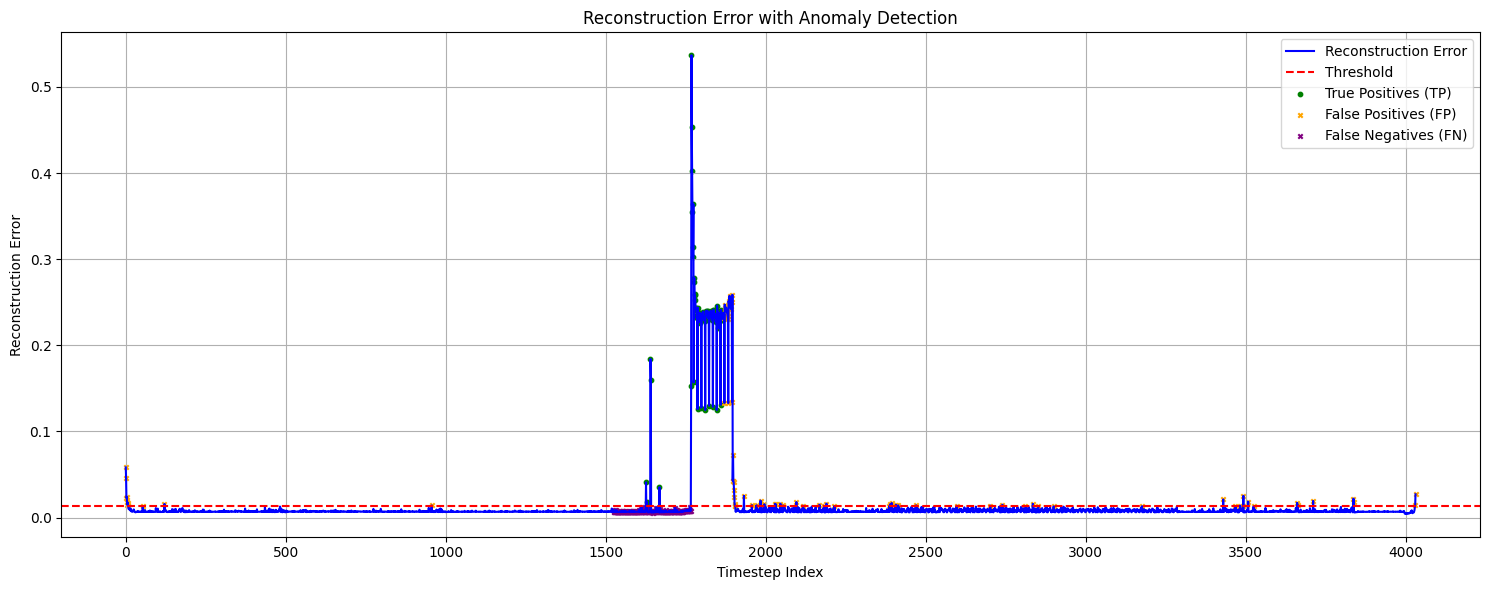

Actual vs Reconstructed Data plot saved to results\H1_BaseModel\ec2_cpu_utilization_825cc2/StaticThreshold\actual_vs_reconstructed_data.png


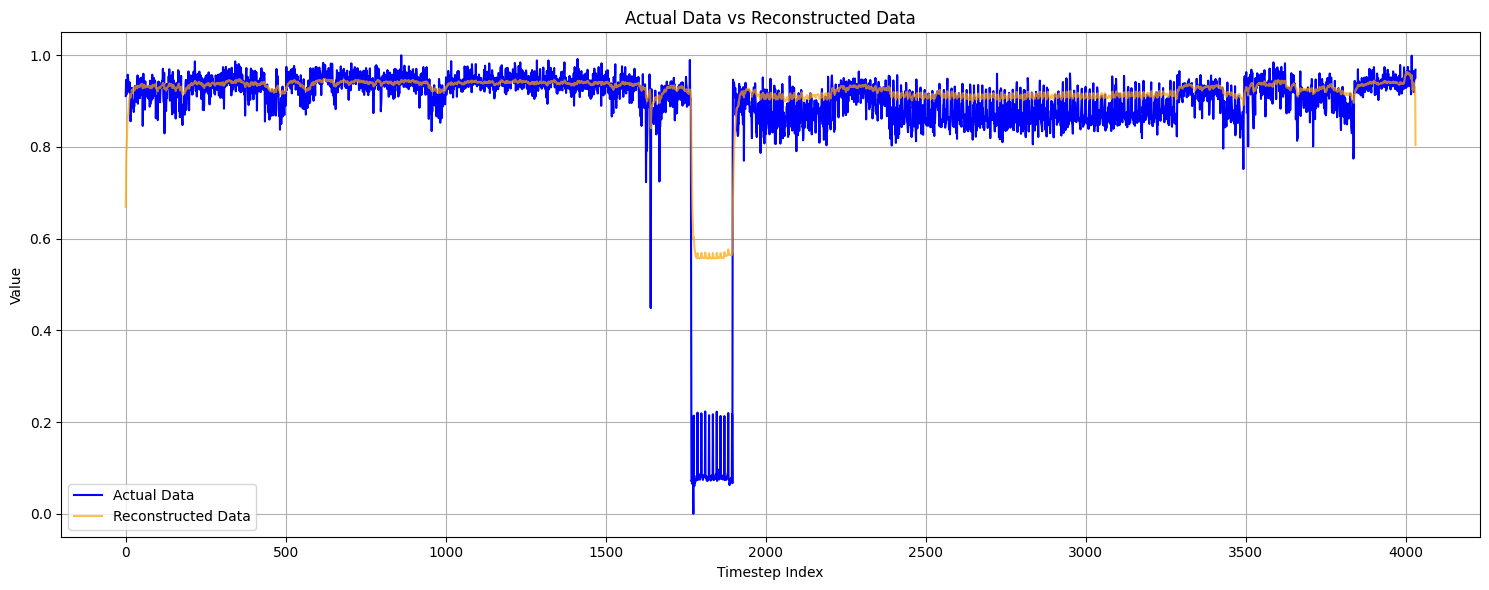

ROC curve plot saved to results\H1_BaseModel\ec2_cpu_utilization_825cc2/StaticThreshold\roc_curve_all_data.png


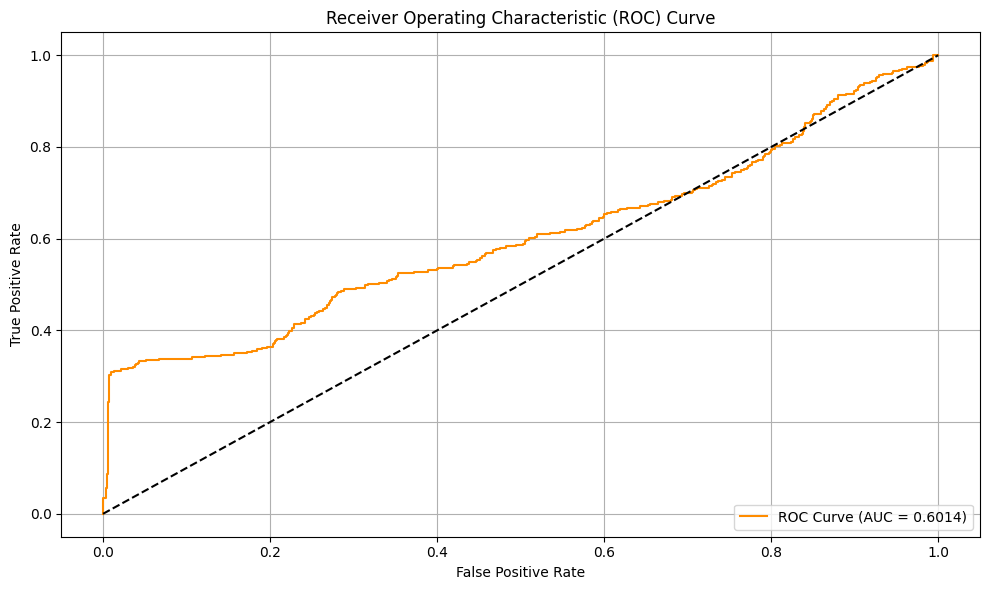

PR curve plot saved to results\H1_BaseModel\ec2_cpu_utilization_825cc2/StaticThreshold\pr_curve_all_data.png


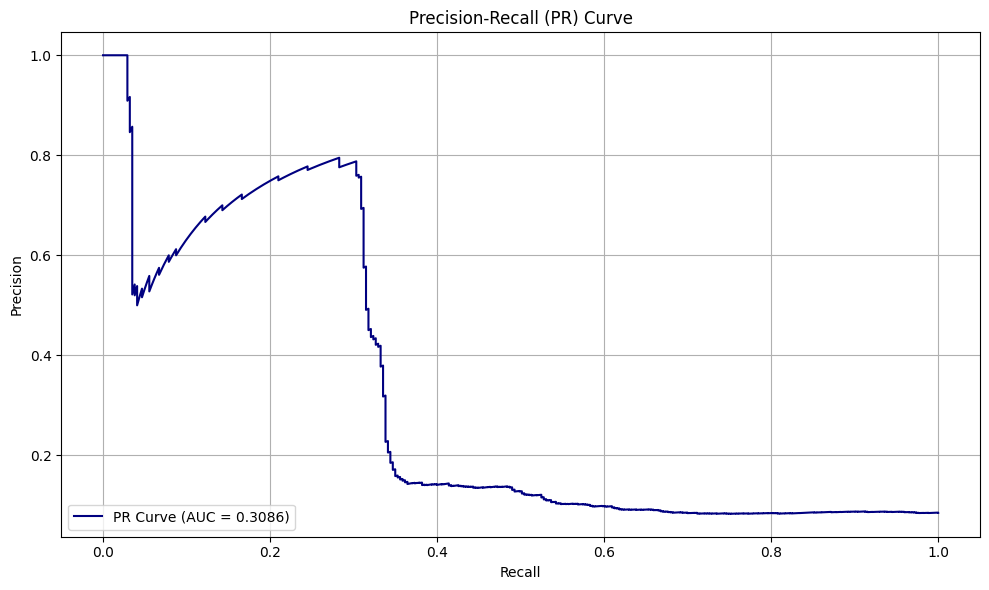

Confusion matrix plot saved to results\H1_BaseModel\ec2_cpu_utilization_825cc2/StaticThreshold\confusion_matrix.png


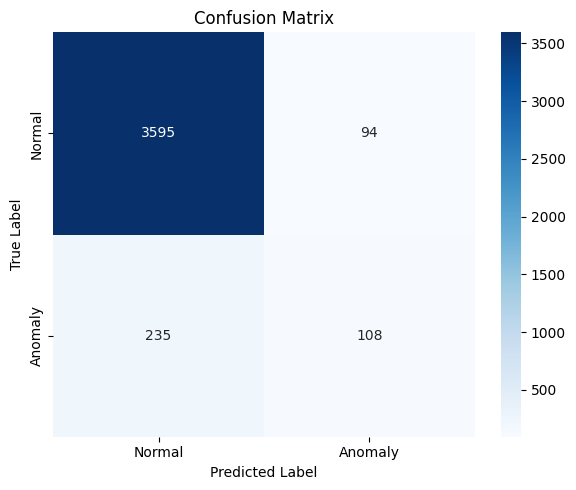

Reconstruction error with anomalies plot saved to results\H1_BaseModel\ec2_cpu_utilization_825cc2/StaticThreshold\reconstruction_error_with_anomalies_static.png


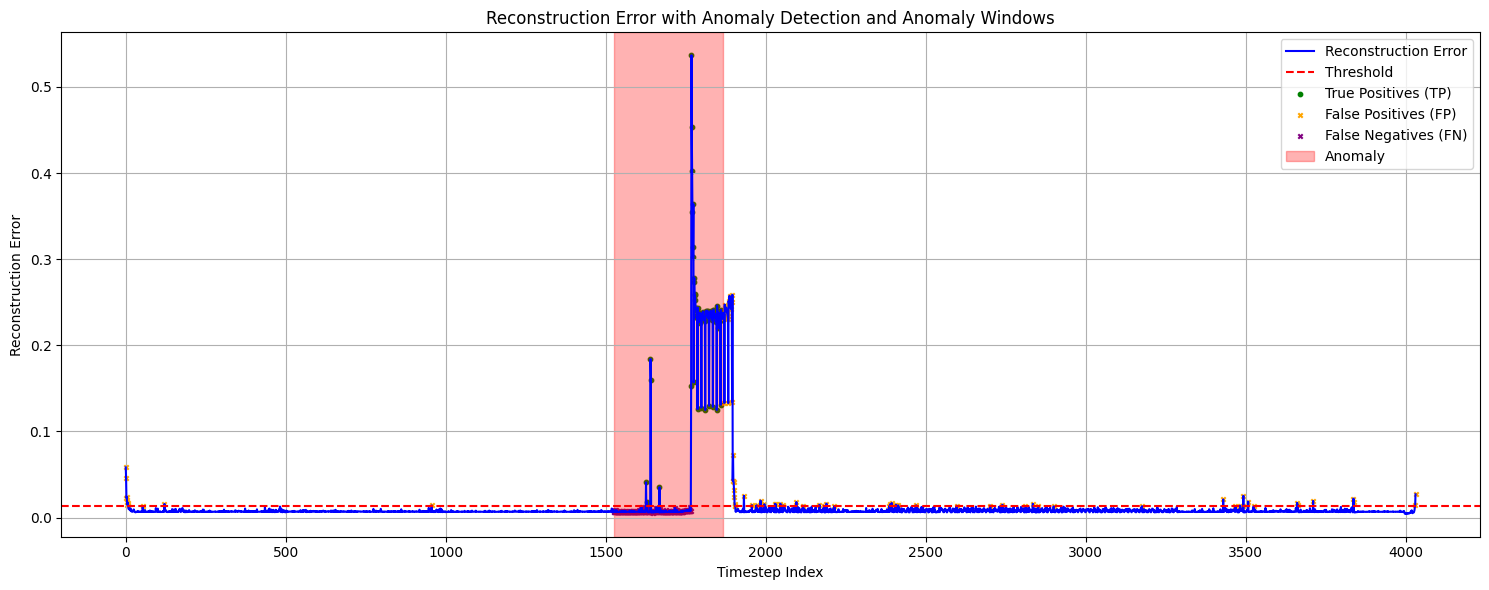

In [29]:
# 테스트 실행 (Static Threshold)
evaluate_and_visualize(
    all_errors=all_errors,
    reconstructed_data=reconstructed_data,
    binary_labels=binary_labels,
    actual_data=test_abnormal_data,
    h=h+'/StaticThreshold',
    threshold_method='static',
    threshold_percentile=95,
)

Using dynamic Reconstruction Error Threshold based on 20-window moving average and 1.0*std
[Classification Metrics]
Precision: 0.0771
Recall: 0.1341
F1-Score: 0.0979
ROC AUC: 0.6690
PR AUC: 0.3226
Cohen Kappa: -0.0114

Reconstruction error plot saved to results\H1_BaseModel\ec2_cpu_utilization_825cc2/DynamicThresholdwithMA\reconstruction_error_moving_avg_threshold.png


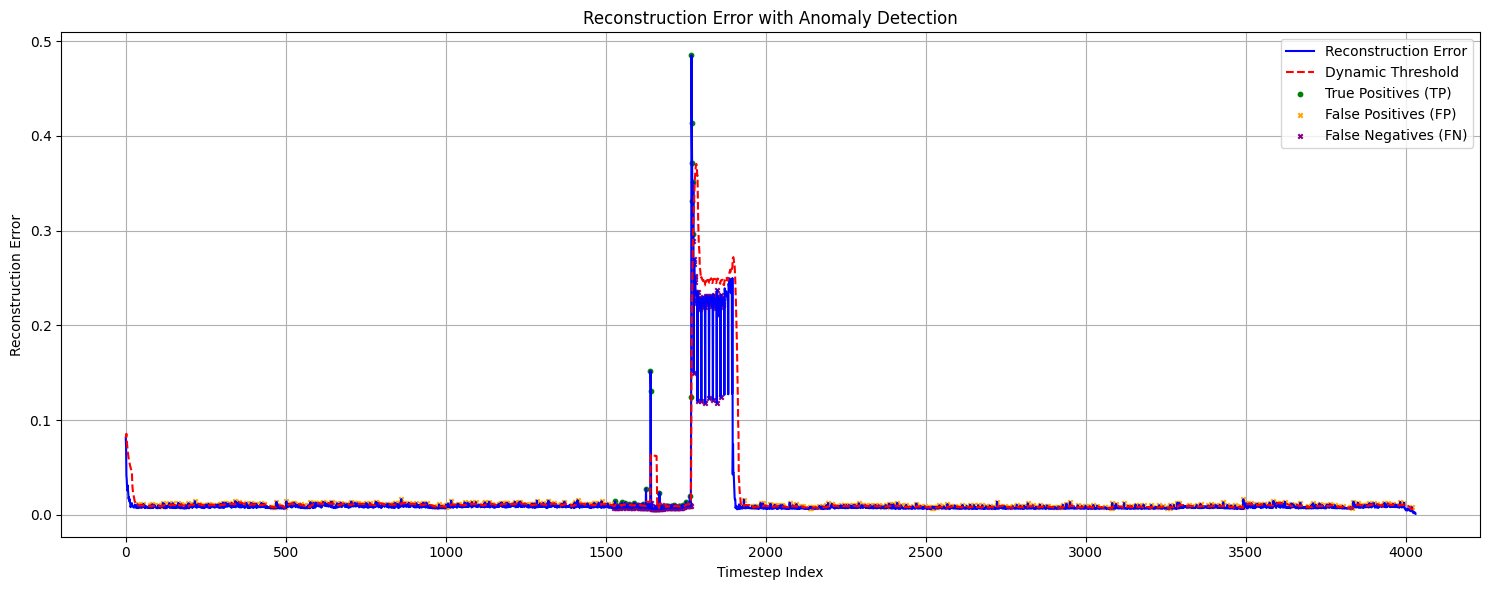

Actual vs Reconstructed Data plot saved to results\H1_BaseModel\ec2_cpu_utilization_825cc2/DynamicThresholdwithMA\actual_vs_reconstructed_data.png


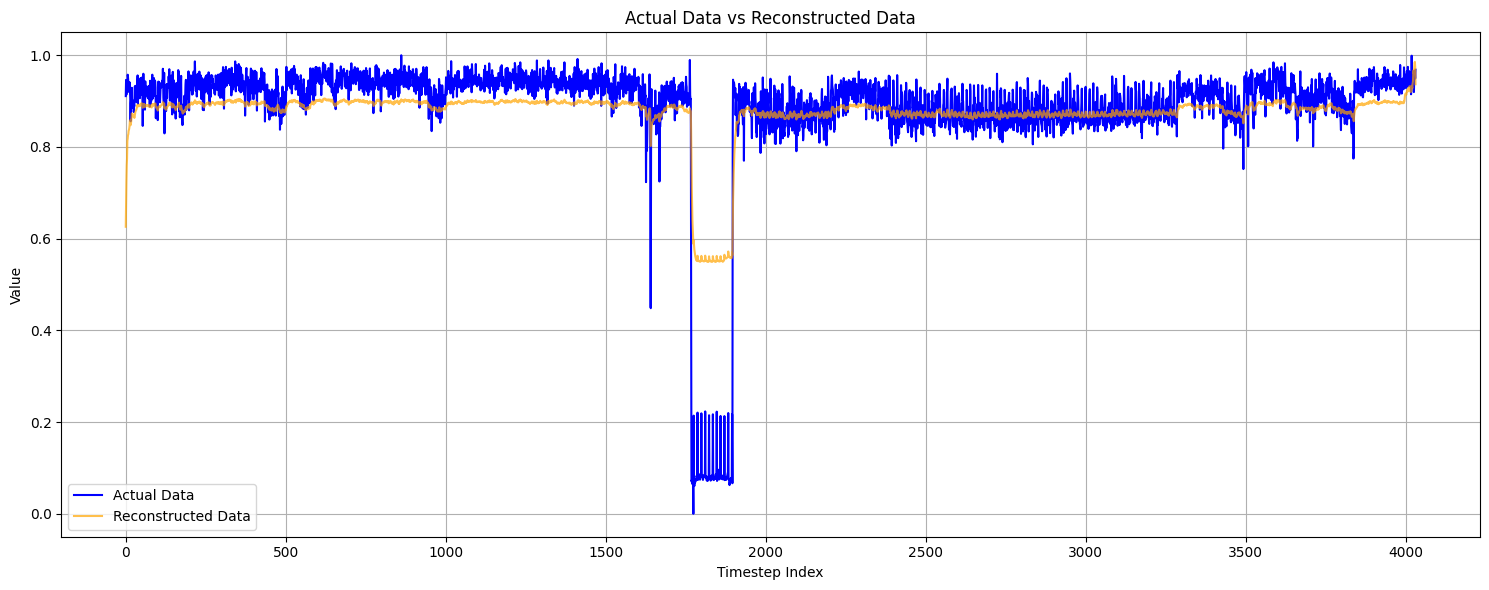

ROC curve plot saved to results\H1_BaseModel\ec2_cpu_utilization_825cc2/DynamicThresholdwithMA\roc_curve_all_data.png


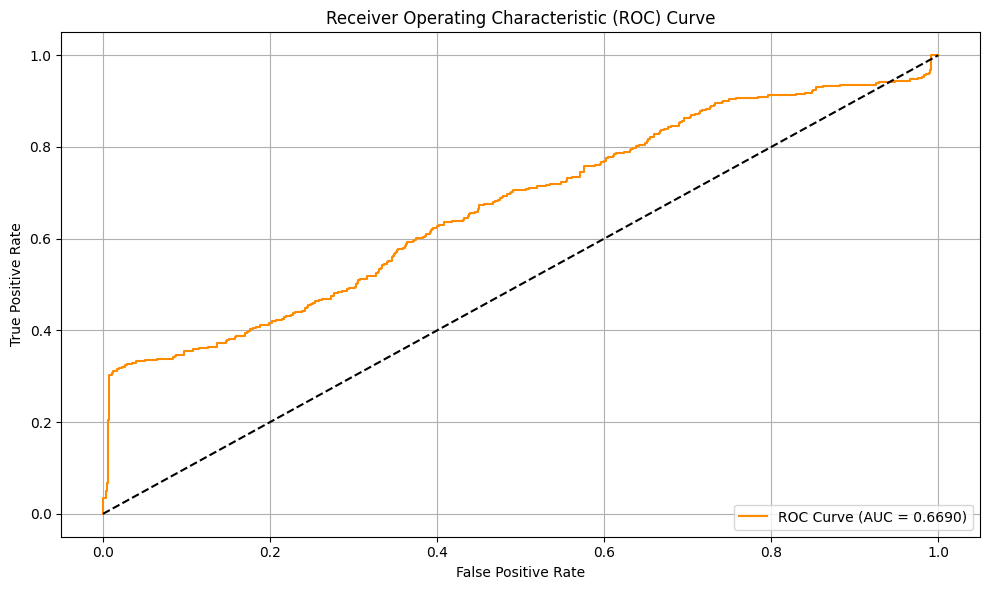

PR curve plot saved to results\H1_BaseModel\ec2_cpu_utilization_825cc2/DynamicThresholdwithMA\pr_curve_all_data.png


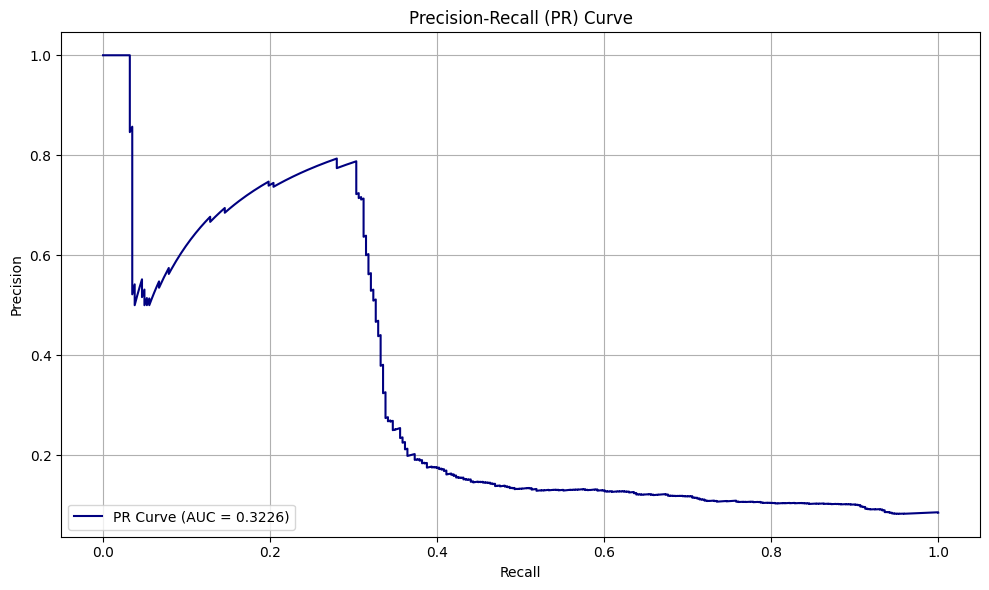

Confusion matrix plot saved to results\H1_BaseModel\ec2_cpu_utilization_825cc2/DynamicThresholdwithMA\confusion_matrix.png


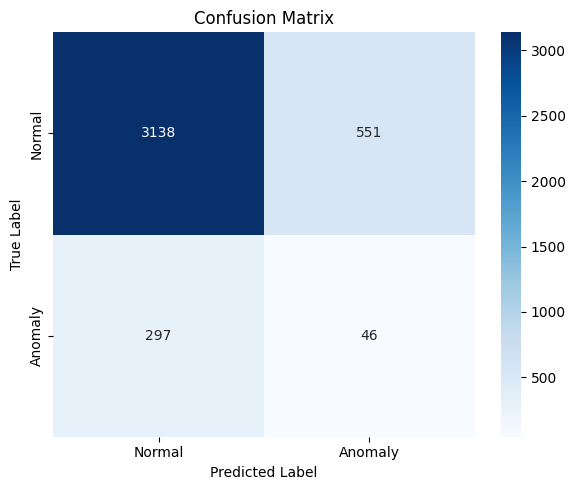

Reconstruction error with anomalies plot saved to results\H1_BaseModel\ec2_cpu_utilization_825cc2/DynamicThresholdwithMA\reconstruction_error_with_anomalies_moving_avg.png


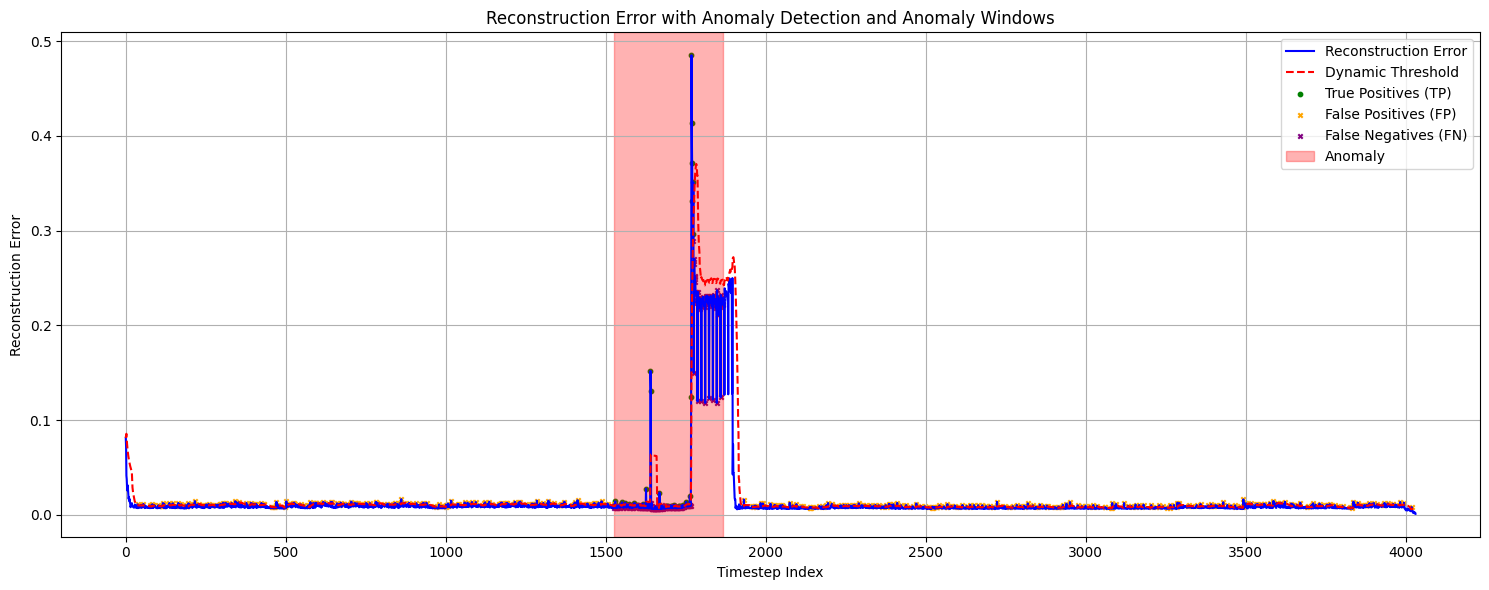

In [5]:
# 테스트 실행 (Dynamic Threshold, Moving Average)
evaluate_and_visualize(
    all_errors=all_errors,
    reconstructed_data=reconstructed_data,
    binary_labels=binary_labels,
    actual_data=test_abnormal_data,
    h=h+'/DynamicThresholdwithMA',
    threshold_method='moving_avg',
    k=1.0
)

Fitting GARCH(1,1) model on scaled reconstruction errors...
                       Zero Mean - GARCH Model Results                        
Dep. Variable:                      y   R-squared:                       0.000
Mean Model:                 Zero Mean   Adj. R-squared:                  0.000
Vol Model:                      GARCH   Log-Likelihood:                24988.7
Distribution:                  Normal   AIC:                          -49971.3
Method:            Maximum Likelihood   BIC:                          -49952.4
                                        No. Observations:                 4032
Date:                Wed, Dec 04 2024   Df Residuals:                     4032
Time:                        02:50:55   Df Model:                            0
                              Volatility Model                              
                 coef    std err          t      P>|t|      95.0% Conf. Int.
---------------------------------------------------------------------------

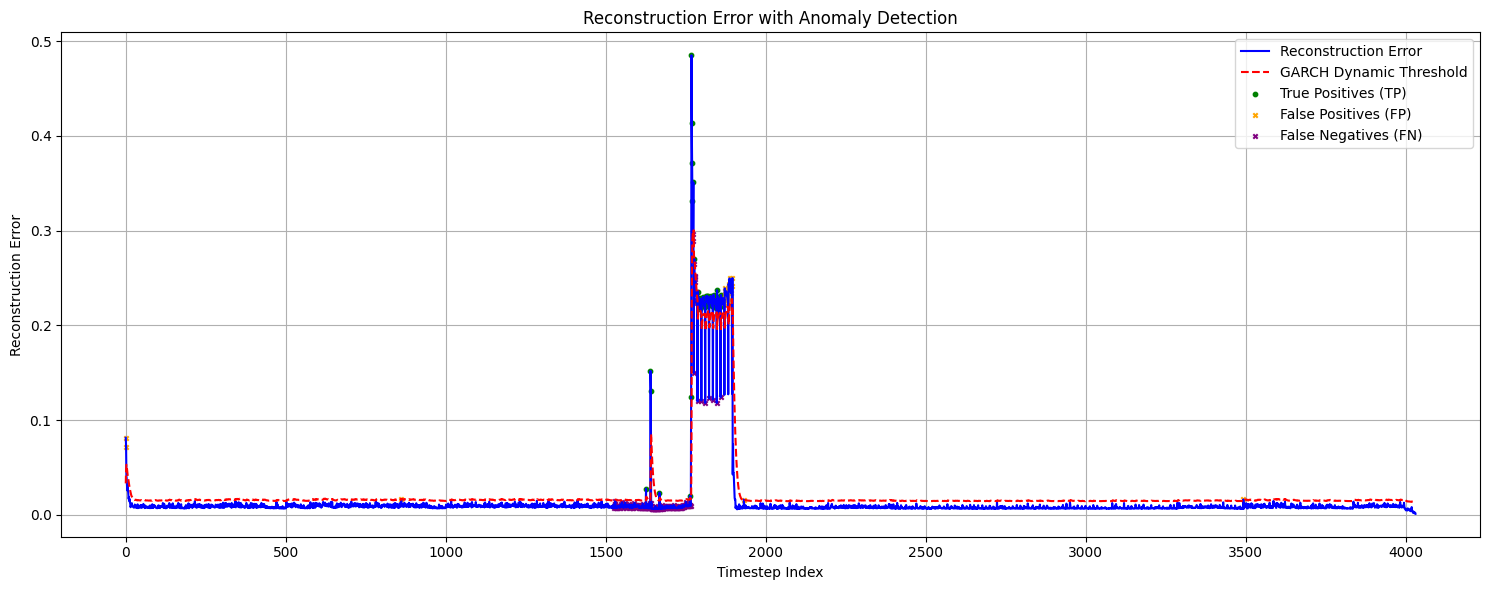

Actual vs Reconstructed Data plot saved to results\H1_BaseModel\ec2_cpu_utilization_825cc2/DynamicThresholdwithGARCH\actual_vs_reconstructed_data.png


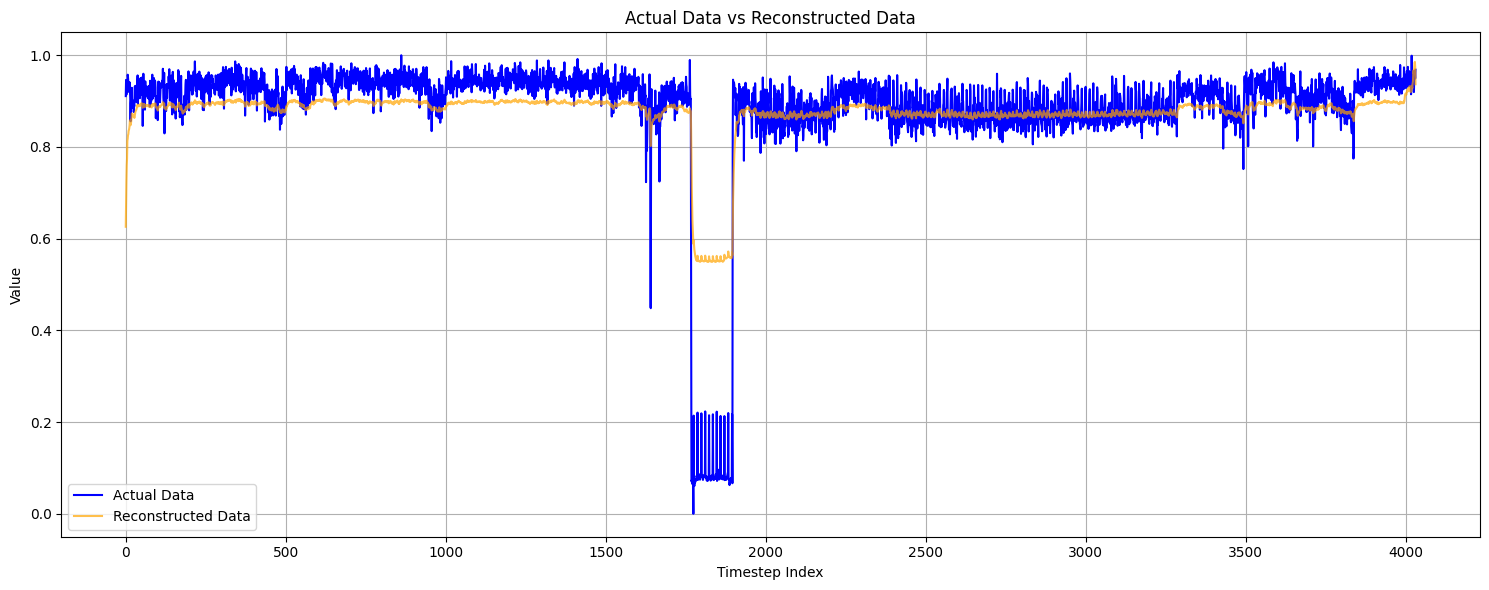

ROC curve plot saved to results\H1_BaseModel\ec2_cpu_utilization_825cc2/DynamicThresholdwithGARCH\roc_curve_all_data.png


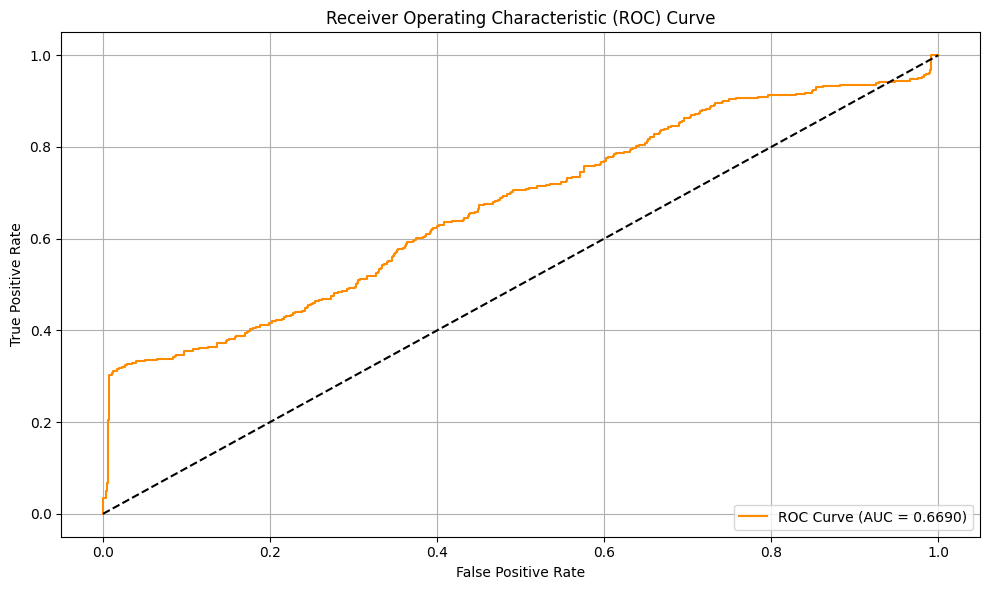

PR curve plot saved to results\H1_BaseModel\ec2_cpu_utilization_825cc2/DynamicThresholdwithGARCH\pr_curve_all_data.png


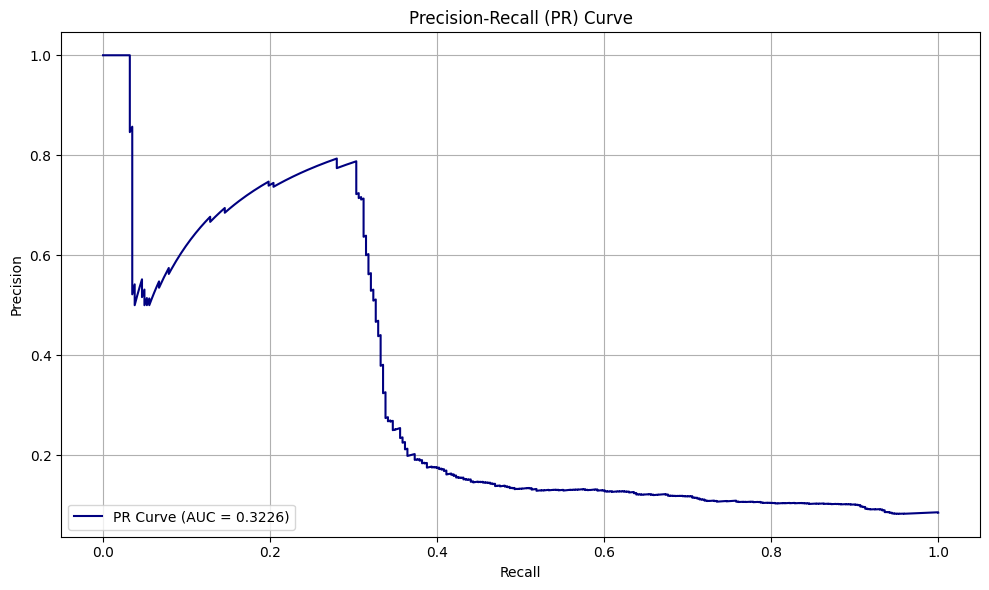

Confusion matrix plot saved to results\H1_BaseModel\ec2_cpu_utilization_825cc2/DynamicThresholdwithGARCH\confusion_matrix.png


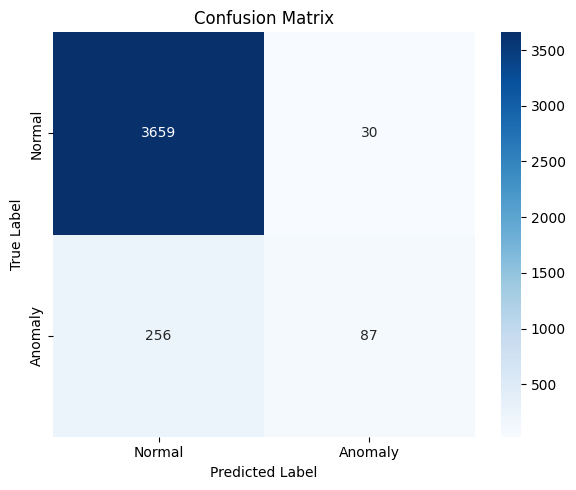

Reconstruction error with anomalies plot saved to results\H1_BaseModel\ec2_cpu_utilization_825cc2/DynamicThresholdwithGARCH\reconstruction_error_with_anomalies_garch.png


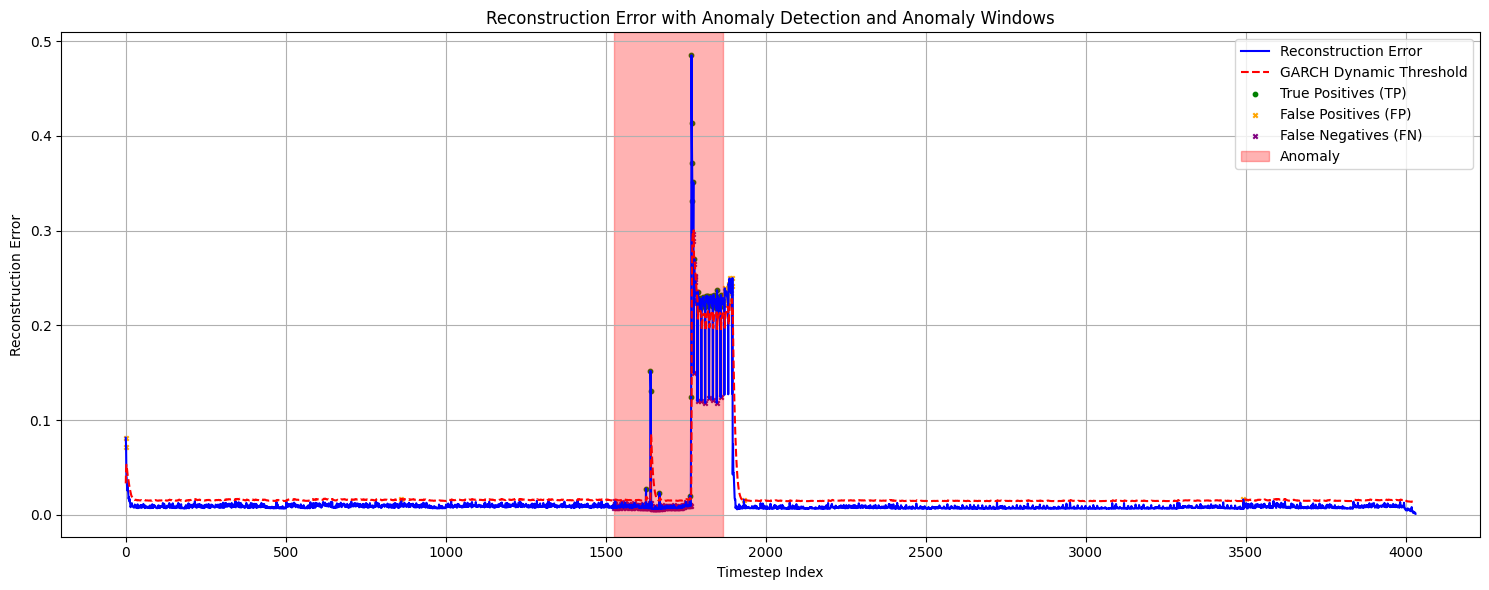

In [6]:
# 테스트 실행 (Dynamic Threshold, GARCH)
evaluate_and_visualize(
    all_errors=all_errors,
    reconstructed_data=reconstructed_data,
    binary_labels=binary_labels,
    actual_data=test_abnormal_data,
    h=h+'/DynamicThresholdwithGARCH',
    threshold_method='garch',
    k=1.0,
)

# art_daily_jumpsup

## Train

Hyperparameter & Hypothesis Number Setting Complete.
Model Initialization Complete.
Processing file: artificialWithAnomaly/art_daily_jumpsup.csv
Data Load Complete.
Loss function & Optimizer Complete.
[Args]
{'N': 10, 'input_size': 1, 'hidden_size': 8, 'output_size': 1, 'num_layers': 1, 'limit_skip_steps': 10, 'learning_rate': 0.001, 'l1_lambda': 1e-05, 'batch_size': 3997, 'window_size': 36, 'num_epochs': 1000, 'random_seed': 777}

[Model]
ESLAE(
  (autoencoders): ModuleList(
    (0-9): 10 x AutoEncoder(
      (encoder): Encoder(
        (cells): ModuleList(
          (0): sLSTMCell(
            (lstm): LSTMCell(1, 8)
          )
        )
      )
      (decoder): Decoder(
        (cells): ModuleList(
          (0): sLSTMCell(
            (lstm): LSTMCell(1, 8)
          )
        )
        (output_layer): Linear(in_features=8, out_features=1, bias=True)
      )
    )
  )
)

[Data]
Number of samples in train dataset: 3997
Number of batches in train dataloader: 1

[Criterion & Optimizer

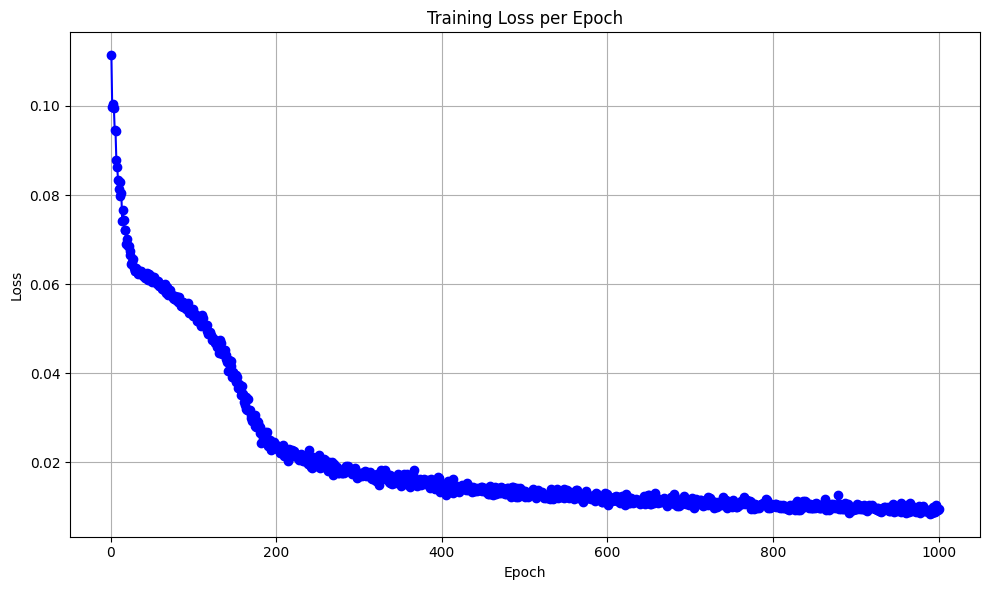

모델 가중치가 H1_BaseModel\art_daily_jumpsup/ensemble_autoencoder_weights.pth'에 저장되었습니다.


In [36]:
set_random_seed()

# 하이퍼파라미터 및 가설 넘버 설정
args = hyperparameter_setting(N=10, hidden_size=8, num_layers=1, num_epochs=1000,
                              window_size=36, l1_lambda=1e-5, limit_skip_steps=10, learning_rate=1e-3)
file_name = './NAB/data/artificialWithAnomaly/art_daily_jumpsup.csv'
h=os.path.join(h_name, os.path.basename(file_name).split('.')[0]) # 꼭 확인하기!
print("Hyperparameter & Hypothesis Number Setting Complete.")

# 디바이스 설정 (GPU가 사용 가능하면 GPU, 아니면 CPU)
model = ESLAE(
    N=args['N'], 
    input_size=args['input_size'],
    hidden_size=args['hidden_size'],
    output_size=args['output_size'],
    num_layers=args['num_layers'],
    limit_skip_steps=args['limit_skip_steps'],
    seed=args['random_seed'],
)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = model.to(device)
print("Model Initialization Complete.")

# Prepare data and create Dataset
abnormal_data, abnormal_label = read_dataset(file_name)
abnormal_data, abnormal_label = abnormal_data[:], abnormal_label[:]  # Remove last data point to fit window and batch size

window_size = args['window_size']
stride = 1

# Create the train dataset
train_dataset = TimeSeriesDataset(abnormal_data, abnormal_label, window_size, stride=stride)
batch_size = args['batch_size'] = len(train_dataset) # args['batch_size']

# Create DataLoaders
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=False, drop_last=True)
print("Data Load Complete.")

# 손실 함수 및 옵티마이저 설정 - 논문에선 Adadelta를 사용했으나, 20 epoch 동안 loss가 떨어지지 않아 Adam으로 대체
criterion = nn.MSELoss() # MSELoss, L1Loss, SmoothL1Loss
optimizer = optim.AdamW(model.parameters(), lr=args['learning_rate'], weight_decay=1e-5)
print("Loss function & Optimizer Complete.")

print("[Args]")
print(args)
print()

print("[Model]")
print(model)
print()

print("[Data]")
print(f"Number of samples in train dataset: {len(train_dataset)}")
print(f"Number of batches in train dataloader: {len(train_dataloader)}")
print()

print("[Criterion & Optimizer]")
print(criterion)
print(optimizer)
print()

# 학습 실행
print('현재 가설명:', h)
print()

train(
    model=model,
    dataloader=train_dataloader,
    criterion=criterion,
    optimizer=optimizer,
    device=device,
    l1_lambda=args['l1_lambda'],
    num_epochs=args['num_epochs'],
    h=h
)

# 모델 가중치 저장
torch.save(model.state_dict(), f'results/{h}/ensemble_autoencoder_weights.pth')
print(f"모델 가중치가 {h}/ensemble_autoencoder_weights.pth'에 저장되었습니다.")

## Test

In [5]:
model.load_state_dict(torch.load(f'results/{h}/ensemble_autoencoder_weights.pth', weights_only=True))
print("모델 가중치가 로드되었습니다.")

# 테스트 파일 불러오기
test_file_name = file_name # Train한 file과 동일한 file로 진행
test_abnormal_data, test_abnormal_label = read_dataset(test_file_name)
test_abnormal_data, test_abnormal_label = test_abnormal_data[:], test_abnormal_label[:]

# 모든 데이터를 테스트에 사용
test_dataset = TimeSeriesDataset(test_abnormal_data, test_abnormal_label, window_size)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, drop_last=True)

total_length = len(test_abnormal_data)

all_errors, reconstructed_data, binary_labels = compute_reconstruction_errors(model, test_dataloader, device, total_length, test_abnormal_label)

모델 가중치가 로드되었습니다.
Processing file: artificialWithAnomaly/art_daily_jumpsup.csv
Testing Complete.


Using static Reconstruction Error Threshold (95th percentile): 0.010492
[Classification Metrics]
Precision: 0.5743
Recall: 0.2878
F1-Score: 0.3835
ROC AUC: 0.5455
PR AUC: 0.2990
Cohen Kappa: 0.3394

Reconstruction error plot saved to results\H1_BaseModel\art_daily_jumpsup/StaticThreshold\reconstruction_error_static_threshold.png


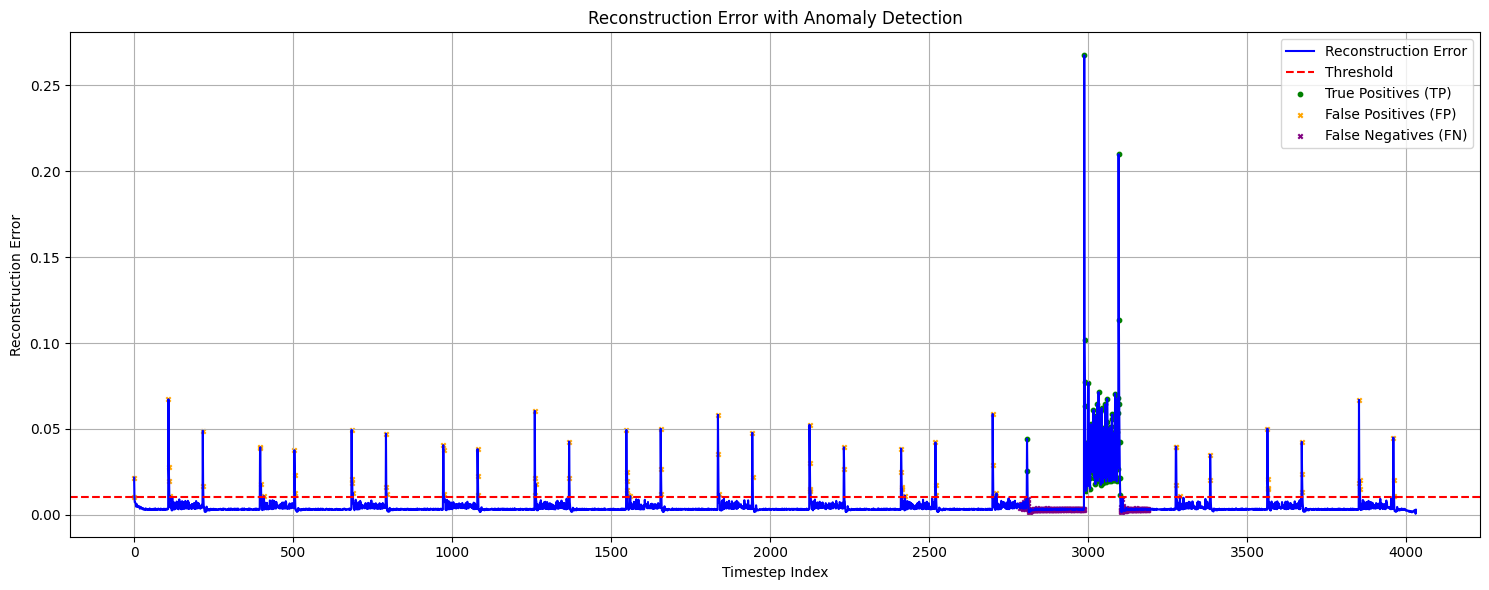

Actual vs Reconstructed Data plot saved to results\H1_BaseModel\art_daily_jumpsup/StaticThreshold\actual_vs_reconstructed_data.png


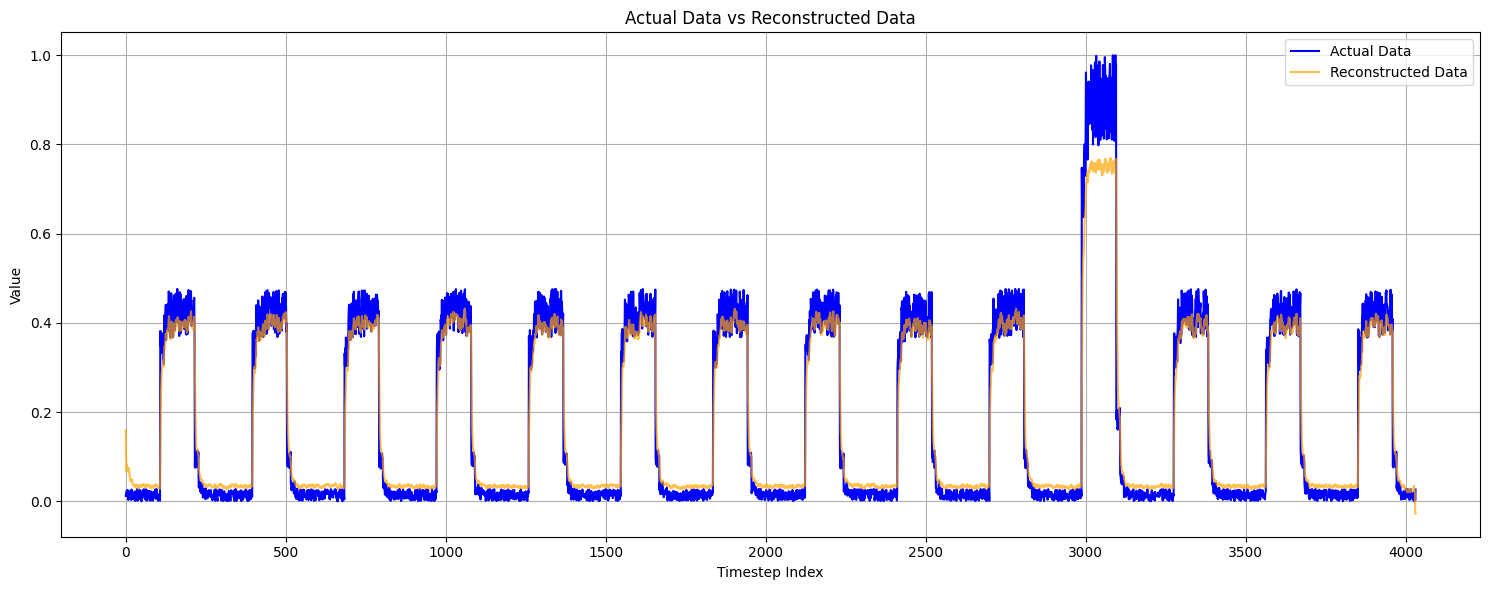

ROC curve plot saved to results\H1_BaseModel\art_daily_jumpsup/StaticThreshold\roc_curve_all_data.png


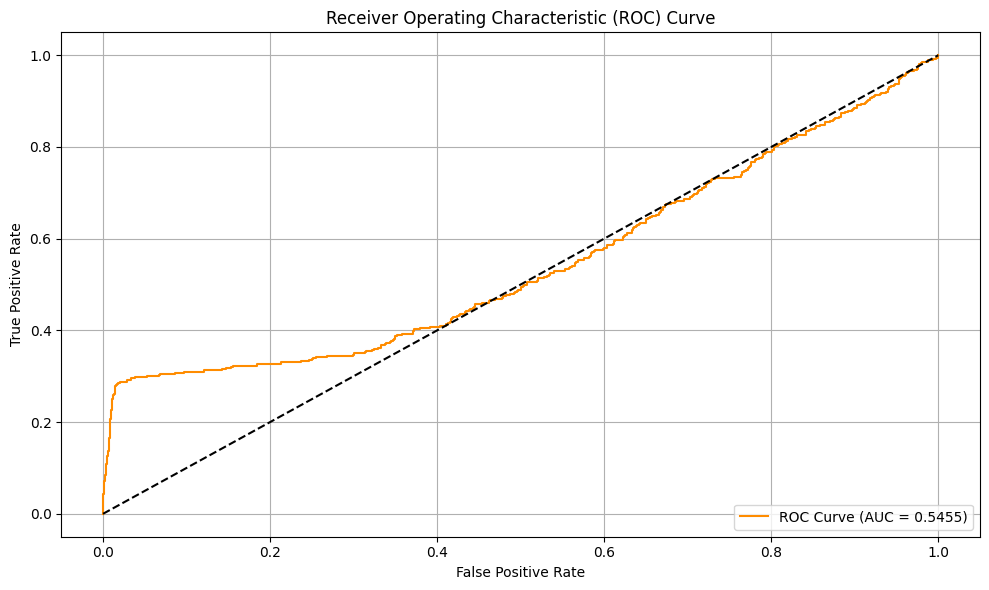

PR curve plot saved to results\H1_BaseModel\art_daily_jumpsup/StaticThreshold\pr_curve_all_data.png


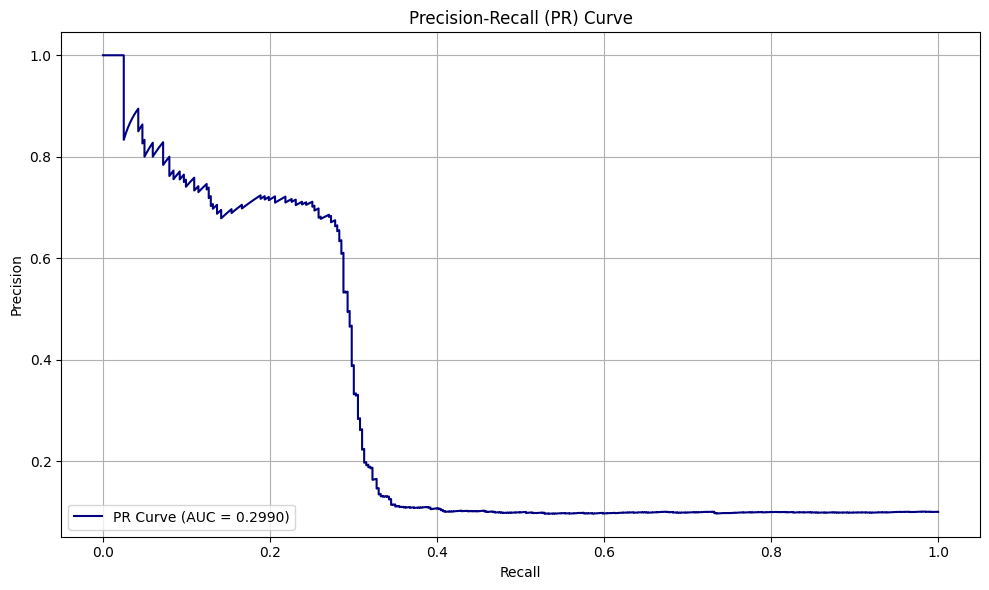

Confusion matrix plot saved to results\H1_BaseModel\art_daily_jumpsup/StaticThreshold\confusion_matrix.png


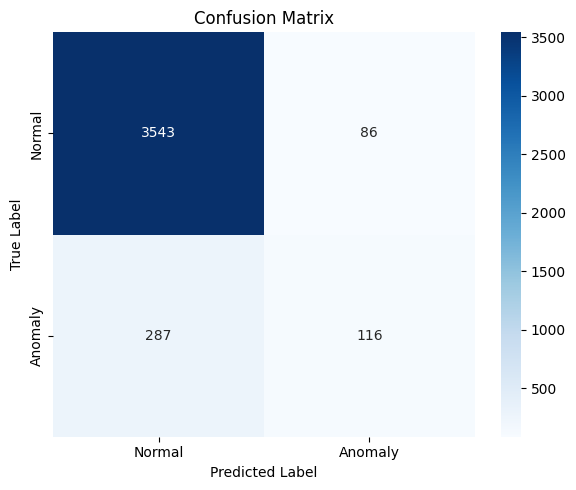

Reconstruction error with anomalies plot saved to results\H1_BaseModel\art_daily_jumpsup/StaticThreshold\reconstruction_error_with_anomalies_static.png


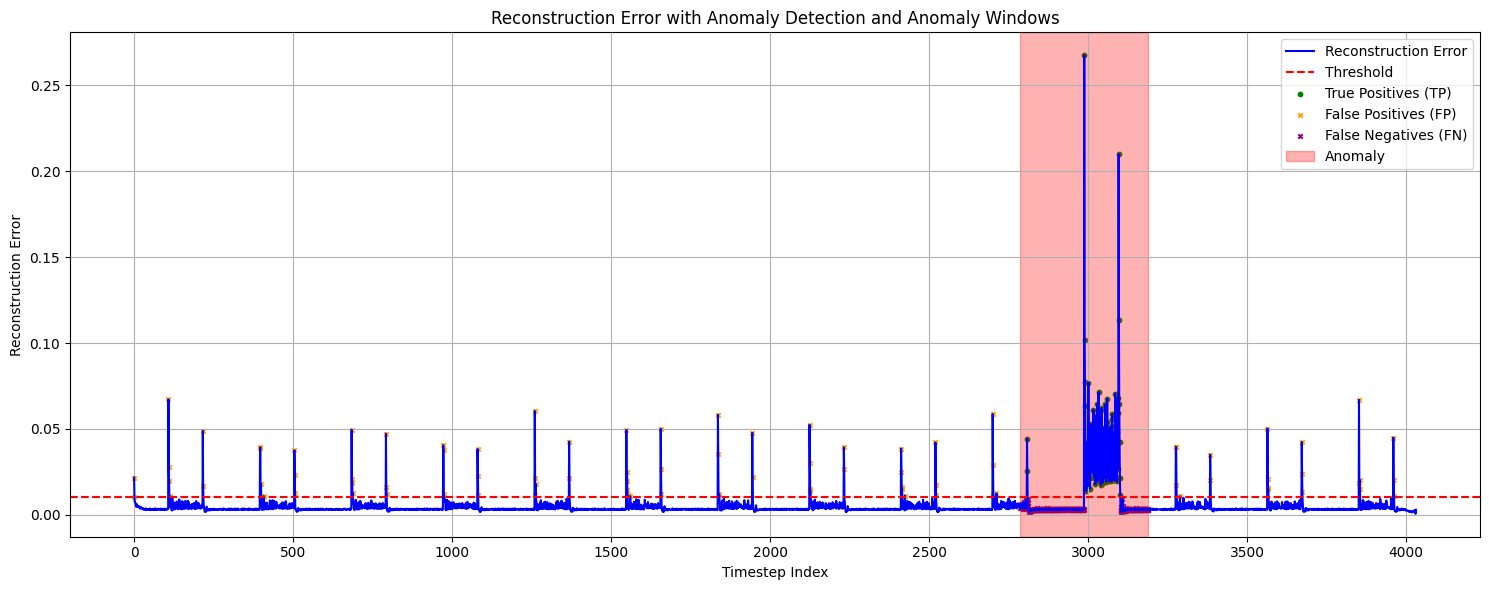

In [7]:
# 테스트 실행 (Static Threshold)
evaluate_and_visualize(
    all_errors=all_errors,
    reconstructed_data=reconstructed_data,
    binary_labels=binary_labels,
    actual_data=test_abnormal_data,
    h=h+'/StaticThreshold',
    threshold_method='static',
    threshold_percentile=95,
)

Using dynamic Reconstruction Error Threshold based on 20-window moving average and 1.0*std
[Classification Metrics]
Precision: 0.0988
Recall: 0.2184
F1-Score: 0.1360
ROC AUC: 0.5357
PR AUC: 0.2569
Cohen Kappa: -0.0019

Reconstruction error plot saved to results\H1_BaseModel\art_daily_jumpsup/DynamicThresholdwithMA\reconstruction_error_moving_avg_threshold.png


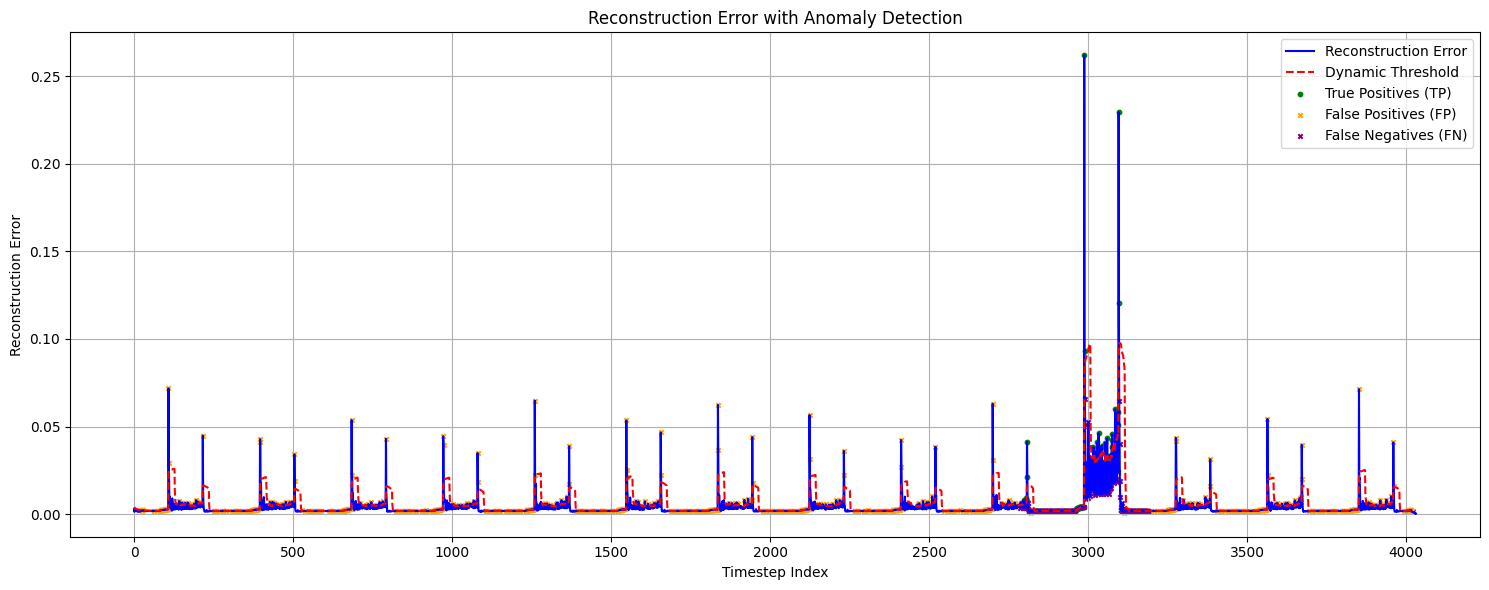

Actual vs Reconstructed Data plot saved to results\H1_BaseModel\art_daily_jumpsup/DynamicThresholdwithMA\actual_vs_reconstructed_data.png


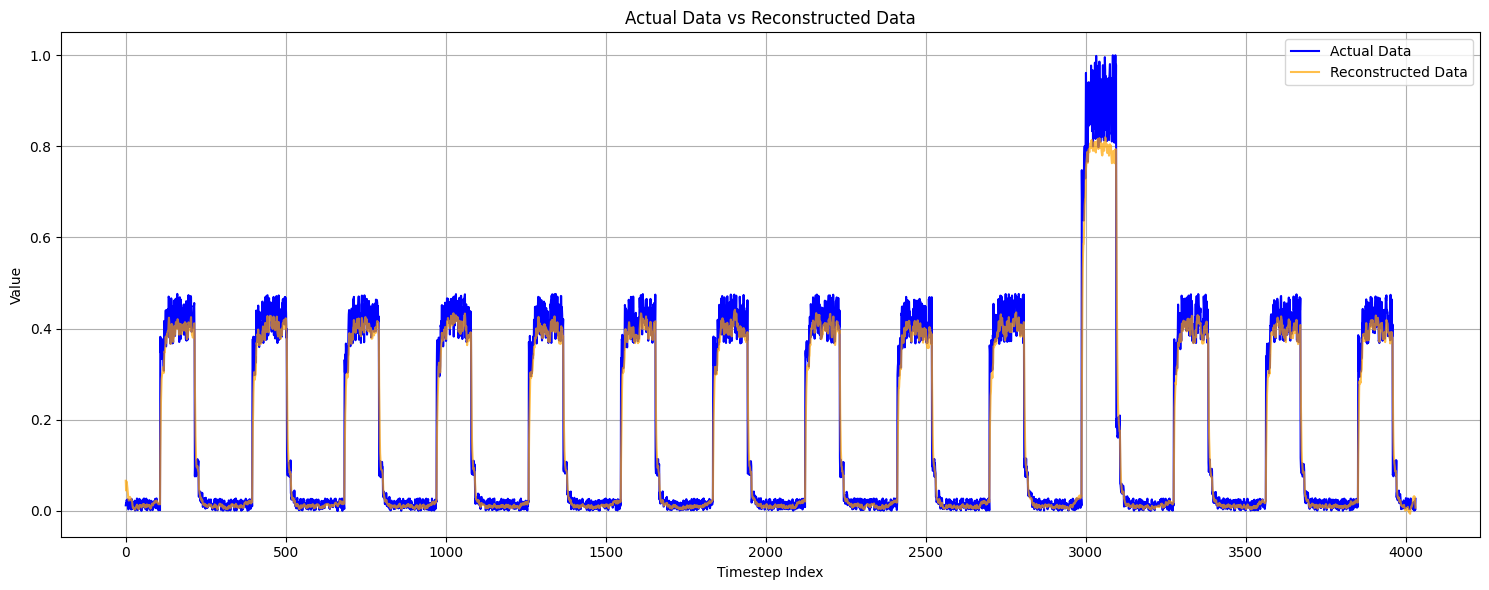

ROC curve plot saved to results\H1_BaseModel\art_daily_jumpsup/DynamicThresholdwithMA\roc_curve_all_data.png


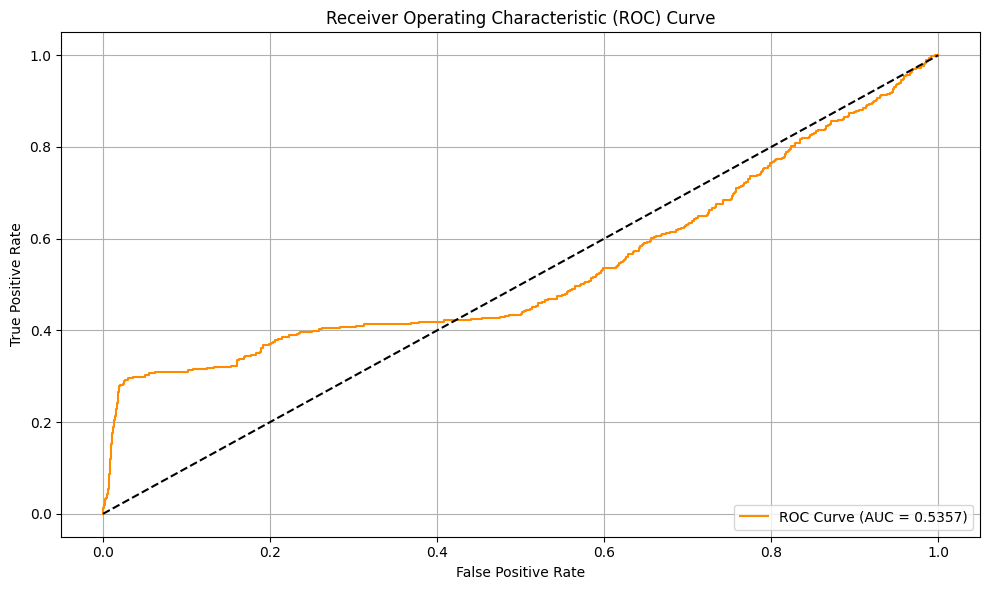

PR curve plot saved to results\H1_BaseModel\art_daily_jumpsup/DynamicThresholdwithMA\pr_curve_all_data.png


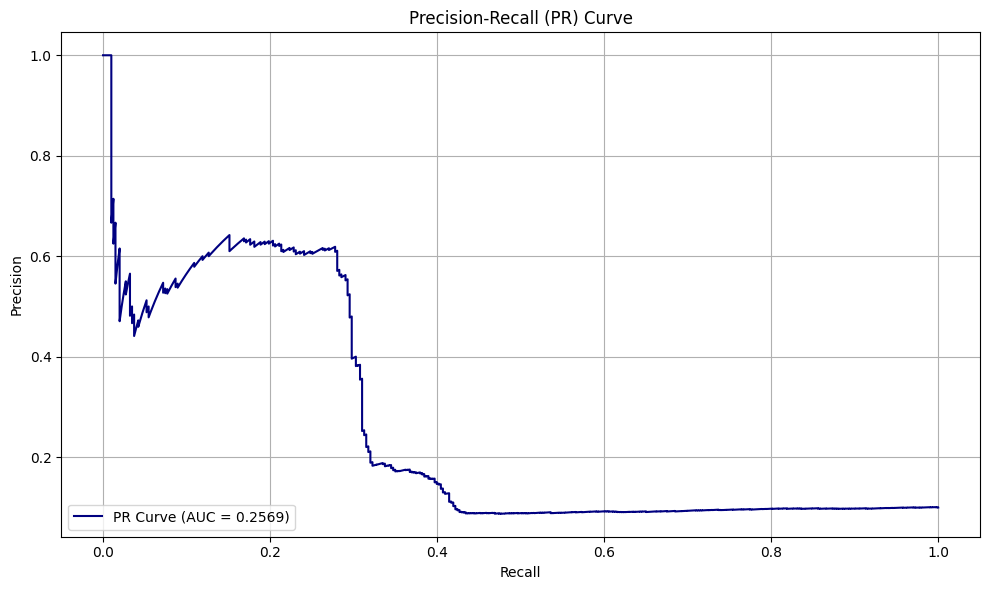

Confusion matrix plot saved to results\H1_BaseModel\art_daily_jumpsup/DynamicThresholdwithMA\confusion_matrix.png


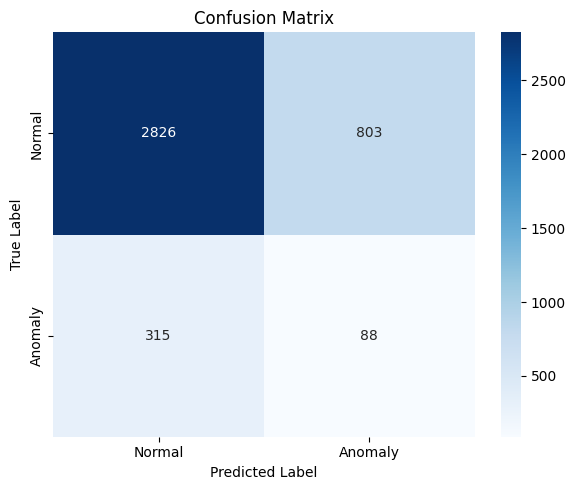

Reconstruction error with anomalies plot saved to results\H1_BaseModel\art_daily_jumpsup/DynamicThresholdwithMA\reconstruction_error_with_anomalies_moving_avg.png


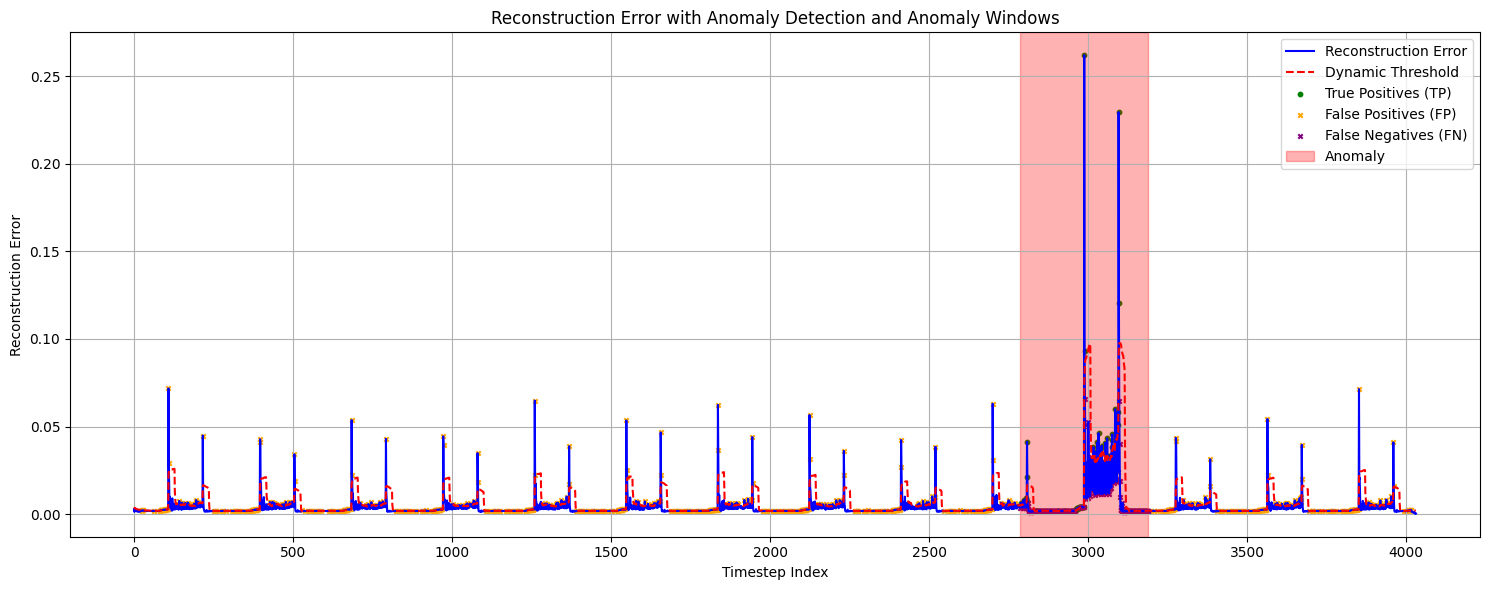

In [57]:
# 테스트 실행 (Dynamic Threshold, Moving Average)
evaluate_and_visualize(
    all_errors=all_errors,
    reconstructed_data=reconstructed_data,
    binary_labels=binary_labels,
    actual_data=test_abnormal_data,
    h=h+'/DynamicThresholdwithMA',
    threshold_method='moving_avg',
    k=1.0
)

Fitting GARCH(1,1) model on scaled reconstruction errors...
                       Zero Mean - GARCH Model Results                        
Dep. Variable:                      y   R-squared:                       0.000
Mean Model:                 Zero Mean   Adj. R-squared:                  0.000
Vol Model:                      GARCH   Log-Likelihood:                33562.3
Distribution:                  Normal   AIC:                          -67118.6
Method:            Maximum Likelihood   BIC:                          -67099.7
                                        No. Observations:                 4032
Date:                Wed, Dec 04 2024   Df Residuals:                     4032
Time:                        03:30:25   Df Model:                            0
                               Volatility Model                              
                 coef    std err          t      P>|t|       95.0% Conf. Int.
-------------------------------------------------------------------------

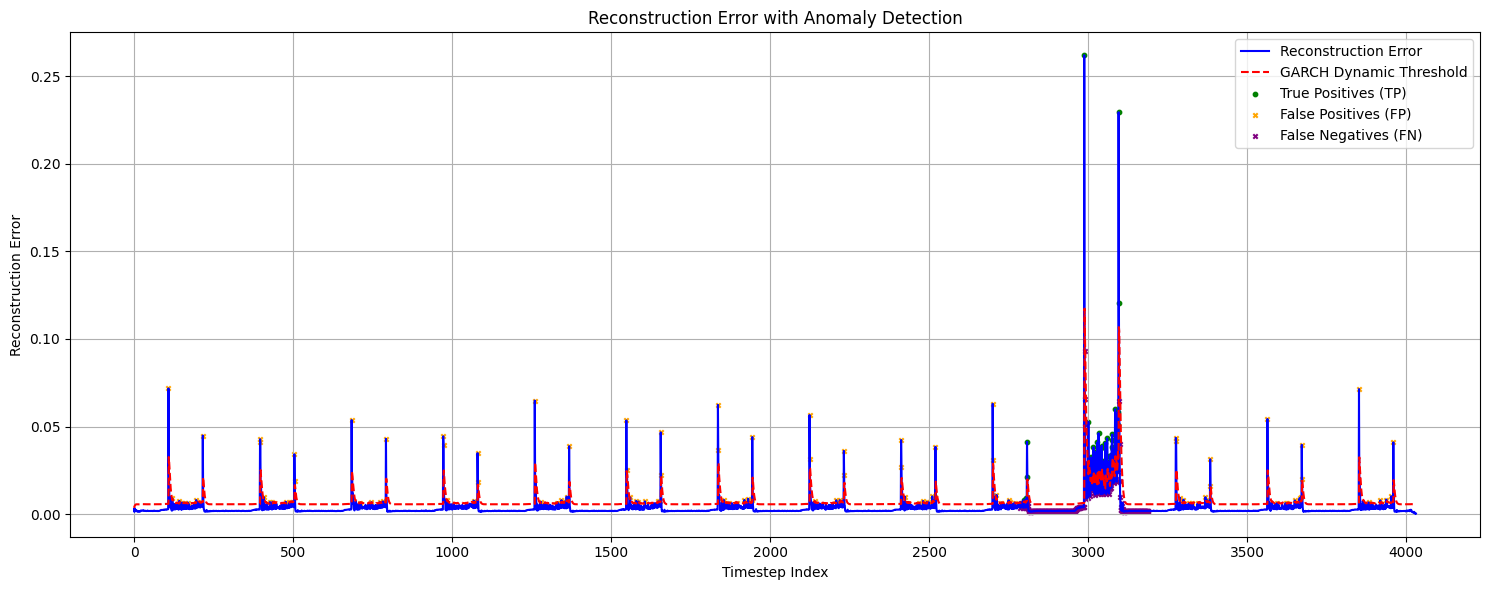

Actual vs Reconstructed Data plot saved to results\H1_BaseModel\art_daily_jumpsup/DynamicThresholdwithGARCH\actual_vs_reconstructed_data.png


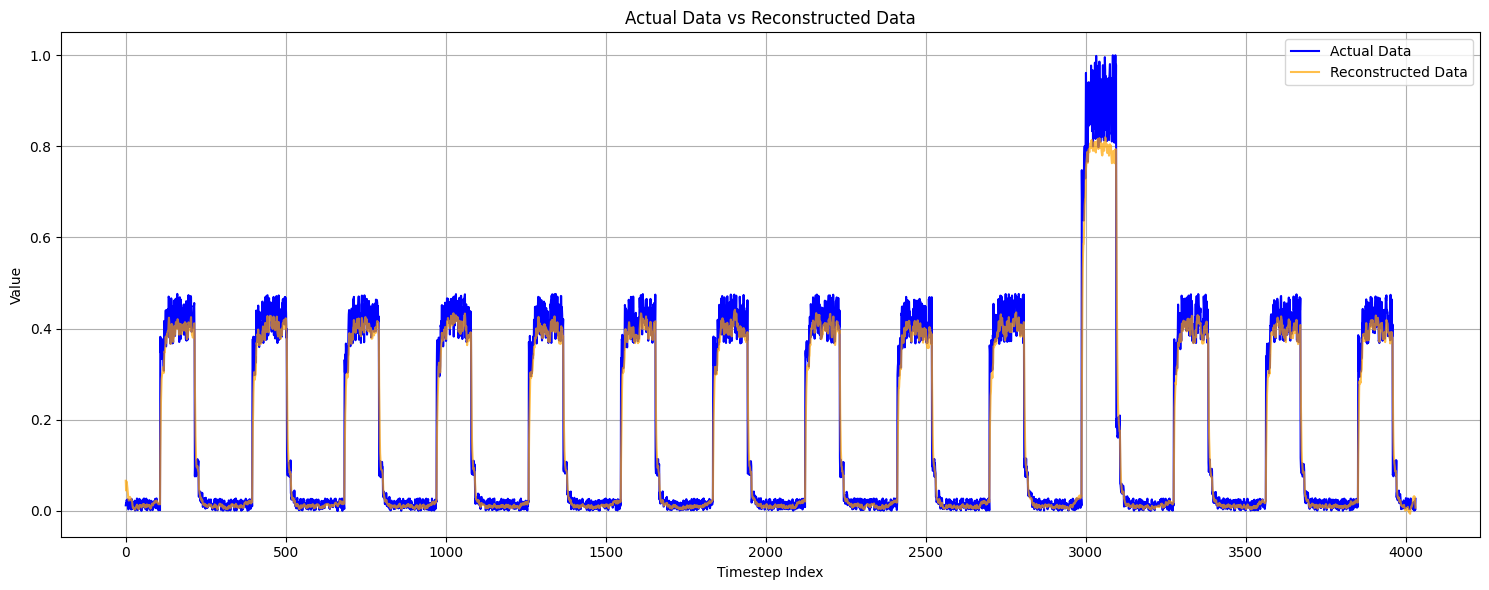

ROC curve plot saved to results\H1_BaseModel\art_daily_jumpsup/DynamicThresholdwithGARCH\roc_curve_all_data.png


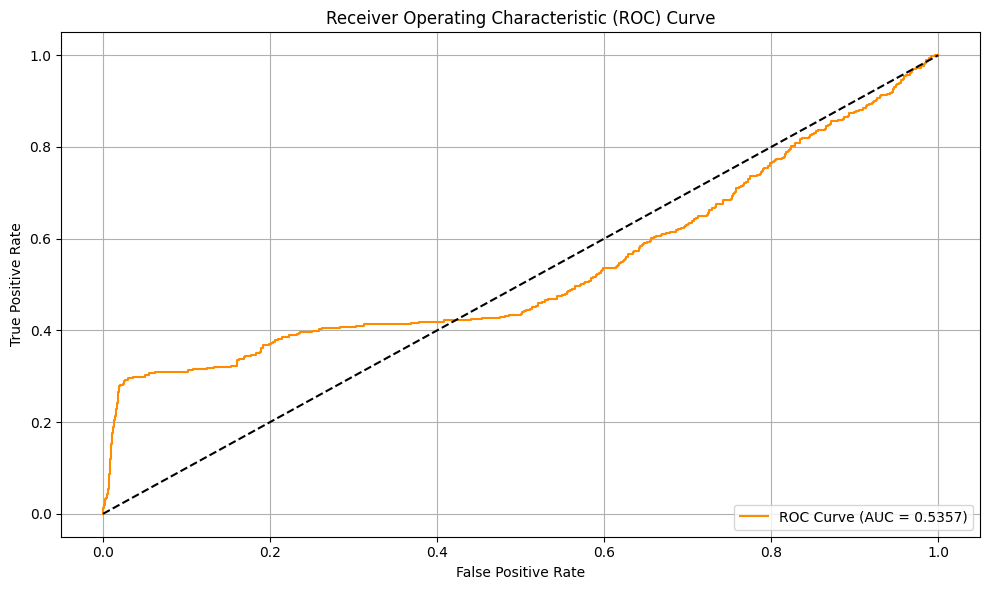

PR curve plot saved to results\H1_BaseModel\art_daily_jumpsup/DynamicThresholdwithGARCH\pr_curve_all_data.png


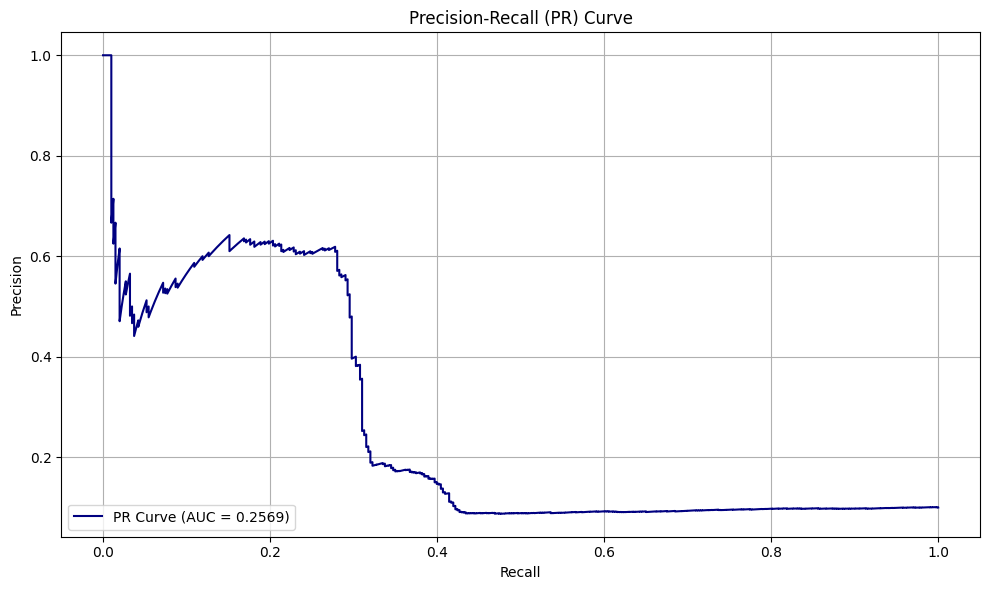

Confusion matrix plot saved to results\H1_BaseModel\art_daily_jumpsup/DynamicThresholdwithGARCH\confusion_matrix.png


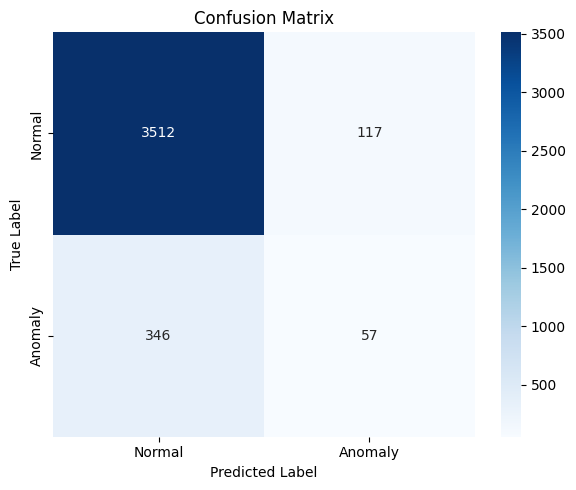

Reconstruction error with anomalies plot saved to results\H1_BaseModel\art_daily_jumpsup/DynamicThresholdwithGARCH\reconstruction_error_with_anomalies_garch.png


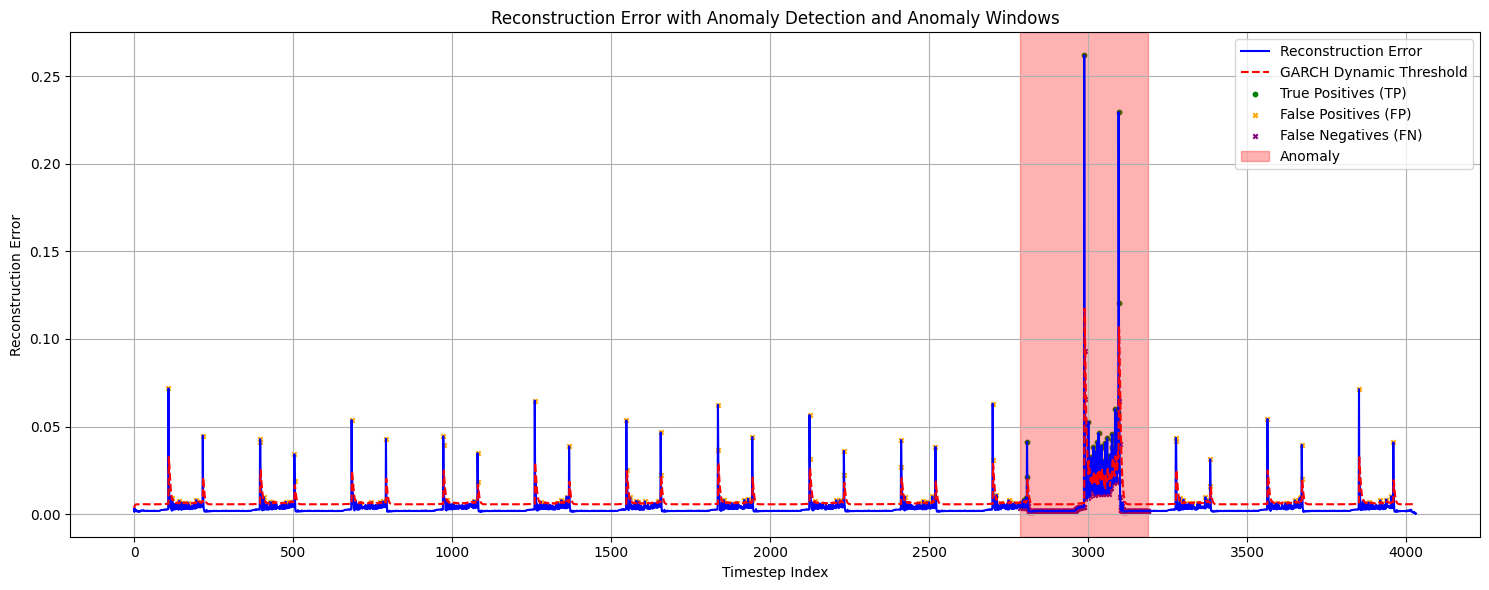

In [58]:
# 테스트 실행 (Dynamic Threshold, GARCH)
evaluate_and_visualize(
    all_errors=all_errors,
    reconstructed_data=reconstructed_data,
    binary_labels=binary_labels,
    actual_data=test_abnormal_data,
    h=h+'/DynamicThresholdwithGARCH',
    threshold_method='garch',
    k=1.0,
)